In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os
import sys
from skipgram_10k import *
from sec_10k_dataset import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats
from collections import defaultdict

## Read list

In [3]:
constraining_path = "/ifs/gsb/usf_interns/LM_word_lists/Constraining_word-list.csv"
interesting_path = "/ifs/gsb/usf_interns/LM_word_lists/Interesting_word-list.csv"
litigious_path = "/ifs/gsb/usf_interns/LM_word_lists/Litigious_word-list.csv"
negative_path = "/ifs/gsb/usf_interns/LM_word_lists/Negative_word-list.csv"
positive_path = "/ifs/gsb/usf_interns/LM_word_lists/Positive_word-list.csv"
superfluous_path = "/ifs/gsb/usf_interns/LM_word_lists/Superfluous_word-list.csv"
uncertainty_path = "/ifs/gsb/usf_interns/LM_word_lists/Uncertainty_word-list.csv"

In [4]:
d = dict()
for path in [constraining_path,interesting_path,litigious_path,negative_path,positive_path,superfluous_path,uncertainty_path]:
    csv_file = pd.read_csv(path)
    ls = [word.lower() for word in csv_file["Word"].values]
    name = path.split("/")[-1].split(".")[0]
    d[name] = ls

## Read glove

In [5]:
glove_path = '/ifs/gsb/usf_interns/Skipgram_Complete/glove.6B'

In [6]:
words = []
vectors = []
idx = 0
word2idx = {}
with open(f'{glove_path}/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

In [7]:
glove_embedding = np.stack(vectors,axis = 0)

In [8]:
gl_word_to_ix = {word: i for i, word in enumerate(words)}
gl_ix_to_word = {i: word for i, word in enumerate(words)}

## Read Skipgram model

In [9]:
EMBEDDING_DIM = 50
filesFolder = ''
data = SEC_10K_Dataset(files_folder=filesFolder, context_size=4)

Length of vocabulary 174641
Finished loading saved training data 2020-05-31 14:42:10.255947


In [10]:
vocab = data.vocab
sk_word_to_ix = {word: i for i, word in enumerate(vocab)}
sk_ix_to_word = {i: word for i, word in enumerate(vocab)}

In [11]:
def closest_cosine(vec, embeddings):
    numerator = (embeddings * vec).sum(dim=1)
    denominator = torch.sqrt((embeddings ** 2).sum(dim=1)) * torch.sqrt((vec ** 2).sum())
    similarities = numerator / denominator
    return similarities

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_file = "/ifs/gsb/usf_interns/test_lr/test_lr5/save_optimizer_version/models/state_4"

In [13]:
checkpoint = torch.load(model_file)

In [14]:
checkpoint["state_dict"]

OrderedDict([('embedding_v.weight',
              tensor([[ 0.0572, -0.0868, -0.5016,  ...,  0.5276, -0.2215,  0.5070],
                      [ 1.1295,  0.2978, -0.6977,  ...,  0.0910, -0.9851, -0.0920],
                      [-0.6026, -0.5992, -0.1655,  ...,  0.6341, -0.4434, -0.1670],
                      ...,
                      [ 0.4715, -0.6560,  1.3098,  ..., -0.9654, -0.1284,  0.1736],
                      [ 0.4567,  0.1411,  0.3633,  ..., -0.5603, -0.0241, -0.5682],
                      [ 0.1486, -0.4291,  0.7095,  ...,  0.3810,  0.7413, -0.2546]])),
             ('embedding_u.weight',
              tensor([[ 0.3420, -0.3962, -0.2008,  ...,  0.5216,  0.0882,  0.7741],
                      [ 1.3281,  0.0317, -0.9109,  ...,  0.1891, -1.0548,  0.2775],
                      [-0.5253, -0.8708, -0.0896,  ...,  0.6947, -0.2708, -0.0468],
                      ...,
                      [ 0.3378, -0.6385,  0.9732,  ..., -1.1161, -0.0661, -0.0653],
                      [ 0.8392,

In [15]:
np_embed = checkpoint["state_dict"]["embedding_v.weight"].numpy()

In [16]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model_file = "/ifs/gsb/usf_interns/test_lr/test_lr5/save_optimizer_version/models/state_4"
# model = torch.load(model_file, map_location=device)
# model.eval()

# # Get closest terms to trained embeddings
# embed = model.get_embeddings()
# np_embed = np.array(embed.weight.data)

In [16]:
type(np_embed)

numpy.ndarray

## Read CBOW model

In [17]:
from SEC_10K_Dataset import *

In [18]:
from CBOW_10K import *

In [19]:
cbow_file = '/ifs/gsb/usf_interns/Saved_models_CBOW_GPU/models/model_34'

In [20]:
filesFolder = '/ifs/gsb/usf_interns/Parser_Project/ParsedDocumentsFolder/10KParsed/Sample100_10Ks/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data = SEC_10K_Dataset(filesFolder=filesFolder, CONTEXT_SIZE=4)
model = CBOW_10K(EMBEDDING_DIM, data)
model = torch.load(cbow_file, map_location=device)
model.eval()

CBOW_10K(
  (embeddings): Embedding(106915, 50)
  (linear): Linear(in_features=50, out_features=106915, bias=True)
  (activation): LogSoftmax()
)

In [21]:
embed = model.get_embeddings()
cbow_embed = np.array(embed.weight.data)

In [22]:
cbow_embed.shape

(106915, 50)

In [23]:
vocab_cbow = data.vocab
cb_word_to_ix = {word: i for i, word in enumerate(vocab_cbow)}
cb_ix_to_word = {i: word for i, word in enumerate(vocab_cbow)}

## Find the intersection between glove, our corpus and list words

In [24]:
print("Length of glove vocab:",len(words))
print("Length of skipgram model vocab", len(vocab))
print("Length of cbow model vocab", len(vocab_cbow))

Length of glove vocab: 400000
Length of skipgram model vocab 174641
Length of cbow model vocab 106915


In [25]:
inters = set(words).intersection(set(vocab)).intersection(set(vocab_cbow))

In [26]:
print("Length of intersection", len(inters))

Length of intersection 60984


In [32]:
# Find common word in LM dictionary & glove & our vocab
for key,value in d.items():
    print("key is:",key," length is:",len(value))
    for word in value:
        if word not in inters:
            value.remove(word)
    print("new length is", len(value))
    d[key] = value

key is: Constraining_word-list  length is: 171
new length is 171
key is: Interesting_word-list  length is: 63
new length is 63
key is: Litigious_word-list  length is: 517
new length is 517
key is: Negative_word-list  length is: 1933
new length is 1933
key is: Positive_word-list  length is: 334
new length is 334
key is: Superfluous_word-list  length is: 41
new length is 41
key is: Uncertainty_word-list  length is: 259
new length is 259


## Expansion, bootstrap and overlapping

In [33]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [34]:
def closest_cosine(vec, embeddings):
    numerator = (embeddings * vec).sum(dim=1)
    denominator = torch.sqrt((embeddings ** 2).sum(dim=1)) * torch.sqrt((vec ** 2).sum())
    similarities = numerator / denominator
    return similarities

In [35]:
def generate_dict(name, top, embedding, word_to_ix, ix_to_word):
    exp_dict = {}
    exp_list = []
    for word in d[name]:
        similarity_list = []
        try:
            word_idx = word_to_ix[word]
        except KeyError:
            continue
        similarities = cosine_similarity(embedding[word_idx].reshape(1,50), embedding).reshape(-1,)
    #     print(similarities.shape)
        similarities_l = similarities.argsort()[-top:].reshape(-1,)
    #     print(similarities_l.shape)
        for ix in similarities_l[::-1]:
    #         print(ix)
            similarity_list.append((ix_to_word[ix],similarities[ix]))
            exp_list.append(ix_to_word[ix])
        exp_dict[word] = similarity_list
    return exp_dict

In [36]:
len(d['Interesting_word-list'])

63

In [37]:
def generate_dist(exp_dict,n):
    M = len(exp_dict.keys())
    N = int(0.22*M)
    original = set(exp_dict.keys())

    result = []
    for i in range(n):
        test = random.sample(exp_dict.keys(),N)
        sample_similarities = []
        for word in test:
            sample_similarities += exp_dict[word]
        sorted_sample_similarities = sorted(sample_similarities, key = lambda x: x[1], reverse = True)
        wordset = set()
        for ele in sorted_sample_similarities:
            if len(wordset) < M:
                wordset.add(ele[0])
        length = len(wordset.intersection(original))
        result.append(length)
    return result

# Define some functions for A/B testing

In [38]:
import scipy.stats as st
from scipy import stats

In [39]:
def sample_size_proportions(alpha, effect_size, k, power, pi1, pi2, alternative="not.equal"):
    """Calculate sample size for proportion given all the parameters."""
    if alternative == "not.equal":
        numerator = ((-st.norm.ppf(alpha/2) + st.norm.ppf(power)) ** 2) * (pi1*(1-pi1)/k + pi2*(1-pi2))
    else:
        numerator = ((-st.norm.ppf(alpha) + st.norm.ppf(power)) ** 2) * (pi1*(1-pi1)/k + pi2*(1-pi2))
    denominator = effect_size ** 2
    test_stat = numerator/denominator
    return test_stat

In [40]:
def test_stat(pi1, pi2, n1, n2):
    """Calculate T statistic for further p-value"""
    numerator = pi1-pi2
    pi_hat = (n1*pi1 + n2*pi2)/(n1 + n2)
    denominator = np.sqrt(pi_hat*(1-pi_hat)*(1/n1 + 1/n2))
    return numerator/denominator

In [41]:
def power_proportions(alpha, n2, k, effect_size, pi1=0.1, alternative="not.equal"):
    """Calculate power given all the paramethers."""
    pi2 = pi1+effect_size
    if alternative == 'not.equal':
        test_stat = abs(st.norm.ppf(alpha/2)) - effect_size*((n2)**0.5)/((pi1*(1-pi1))/k + pi2*(1-pi2))*0.5
        prob = 1 - st.norm.cdf((test_stat))
    else:
        test_stat = abs(st.norm.ppf(alpha)) - effect_size*((n2)**0.5)/((pi1*(1-pi1))/k + pi2*(1-pi2))*0.5
        prob = 1 - st.norm.cdf((test_stat))
    return prob

In [42]:
def test_proportion(pi1,pi2,n):
    """H0: pi1 is greater or equal to pi2
       Ha: pi1 is less than pi2.
    """
    eta = abs(pi1-pi2)
    sample_size_required = sample_size_proportions(alpha = 0.05, effect_size = eta, k = 1, power = 0.8, pi1 = pi1, pi2 = pi2, alternative="less than")
    t_stat = test_stat(pi1,pi2, n,n)
    p_value = st.norm.pdf(x = t_stat)
    print("Sample size required for alpha = 0.05, power = 0.8: ",sample_size_required)
    # If by calculation, the sample size is bigger then what we have, we calculate the power given our sample size and alpha.
    if sample_size_required > n:
        power = power_proportions(alpha=0.05, n2=n, k=1, effect_size=eta, pi1=pi1, alternative="less than")
        print("With all the available sample, the power we can achieved is:", power)
    print("T test statistic",t_stat)
    print("P value", p_value)    

**Result for A/B testing(statistically: $\alpha$=0.05,$1-\beta$=0.8) to compare embedding:**
- Glove is better: Uncertainty
- Cannot tell: Interesting, Negative, Litigious, Positive

**If we only look at numbers**

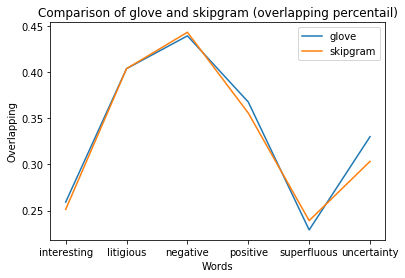

In [10]:
x1 = ['interesting','litigious','negative','positive','superfluous','uncertainty']
y1 = glove_p
plt.plot(x1, y1, label = "glove")
x2 = x1
y2 = sk_p
plt.plot(x2, y2, label = "skipgram")
plt.xlabel('Words')
plt.ylabel('Overlapping')
plt.title('Comparison of glove and skipgram (overlapping percentail)')
plt.legend()
plt.show()

### Constraining

In [43]:
glove_exp_dict0 = generate_dict('Constraining_word-list', 60, glove_embedding, gl_word_to_ix, gl_ix_to_word)

In [44]:
sk_exp_dict0 = generate_dict('Constraining_word-list', 60, np_embed, sk_word_to_ix, sk_ix_to_word)

In [45]:
cb_exp_dict0 = generate_dict('Constraining_word-list', 60, cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [64]:
glove_result0 = generate_dist(glove_exp_dict0,10000)
sk_result0 = generate_dist(sk_exp_dict0,10000)
cb_result0 = generate_dist(cb_exp_dict0,10000)

### Interesting

In [46]:
glove_exp_dict1 = generate_dict('Interesting_word-list', 60, glove_embedding, gl_word_to_ix, gl_ix_to_word)

In [65]:
glove_result1 = generate_dist(glove_exp_dict1,10000)
# plt.hist(glove_result1)
# plt.show()

In [190]:
# print(mean_confidence_interval(glove_result1, confidence=0.95))
# print(mean_confidence_interval(glove_result1, confidence=0.95)[0]/len(glove_exp_dict1.keys()))
# print(len(glove_exp_dict1.keys()))

(16.325861530157106, 16.309325369870194, 16.342397690444017)
0.25914065920884294
63


In [47]:
sk_exp_dict1 = generate_dict('Interesting_word-list', 60, np_embed, sk_word_to_ix, sk_ix_to_word)

In [66]:
sk_result1 = generate_dist(sk_exp_dict1,10000)
# plt.hist(sk_result1)
# plt.show()

In [193]:
print(mean_confidence_interval(sk_result1, confidence=0.95))
print(mean_confidence_interval(sk_result1, confidence=0.95)[0]/len(sk_exp_dict1.keys()))
print(len(sk_exp_dict1.keys()))

(15.82439842040967, 15.809907496277392, 15.838889344541949)
0.25118092730809
63


In [48]:
cb_exp_dict1 = generate_dict('Interesting_word-list', 60, cbow_embed, cb_word_to_ix, sk_ix_to_word)

In [67]:
cb_result1 = generate_dist(cb_exp_dict1,10000)

In [194]:
# For Interesting: cannot really tell
test_proportion(0.25118092730809,0.25914065920884294,35199)

Sample size required for alpha = 0.05, power = 0.8:  37088.6936846811
With all the available sample, the power we can achieved is: 0.6254011714285215
T test statistic -2.422202057462219
P value 0.02122724169047074


### Litigious

In [49]:
glove_exp_dict2 = generate_dict('Litigious_word-list', 60, glove_embedding, gl_word_to_ix, gl_ix_to_word)

In [69]:
glove_result2 = generate_dist(glove_exp_dict2, 10000)
# plt.hist(glove_result2)
# plt.show()

KeyboardInterrupt: 

In [185]:
print(mean_confidence_interval(glove_result2, confidence=0.95))
print(mean_confidence_interval(glove_result2, confidence=0.95)[0]/len(glove_exp_dict2.keys()))
print(len(glove_exp_dict2.keys()))

(202.37158291045998, 202.25707264922116, 202.4860931716988)
0.39143439634518373
517


In [50]:
sk_exp_dict2 = generate_dict('Litigious_word-list', 60, np_embed, sk_word_to_ix, sk_ix_to_word)

In [ ]:
sk_result2 = generate_dist(sk_exp_dict2,10000)
# plt.hist(sk_result2)
# plt.show()

In [186]:
print(mean_confidence_interval(sk_result2, confidence=0.95))
print(mean_confidence_interval(sk_result2, confidence=0.95)[0]/len(sk_exp_dict2.keys()))
print(len(sk_exp_dict2.keys()))

(208.92290063840235, 208.81324273638947, 209.03255854041524)
0.40410619078994653
517


In [51]:
cb_exp_dict2 = generate_dict('Litigious_word-list', 60, cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [70]:
glove_result2 = generate_dist(glove_exp_dict2,10000)
sk_result2 = generate_dist(sk_exp_dict2,10000)
cb_result2 = generate_dist(cb_exp_dict2,10000)

In [188]:
# For Litigious: our model is better
test_proportion(0.39143439634518373,0.40410619078994653,18327)

Sample size required for alpha = 0.05, power = 0.8:  18443.51262171706
With all the available sample, the power we can achieved is: 0.5579448947247945
T test statistic -2.4784008616709223
P value 0.018496496397165545


### Negative

In [52]:
glove_exp_dict3 = generate_dict('Negative_word-list', 60, glove_embedding, gl_word_to_ix, gl_ix_to_word)

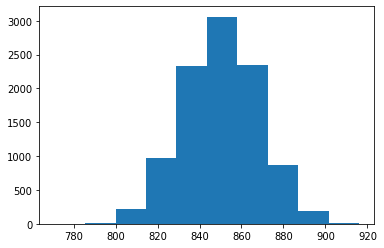

In [157]:
glove_result3 = generate_dist(glove_exp_dict3,10000)
plt.hist(glove_result3)
plt.show()

In [158]:
print(mean_confidence_interval(glove_result3, confidence=0.95))
print(mean_confidence_interval(glove_result3, confidence=0.95)[0]/len(glove_exp_dict3.keys()))
print(len(glove_exp_dict3.keys()))

(850.003, 849.651001425772, 850.354998574228)
0.4397325400931195
1933


In [53]:
sk_exp_dict3 = generate_dict('Negative_word-list', 60, np_embed, sk_word_to_ix, sk_ix_to_word)

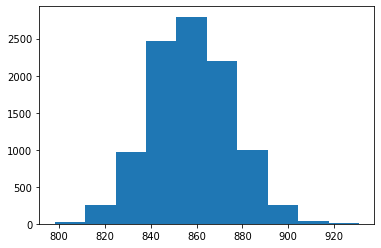

In [159]:
sk_result3 = generate_dist(sk_exp_dict3,10000)
plt.hist(sk_result3)
plt.show()

In [160]:
print(mean_confidence_interval(sk_result3, confidence=0.95))
print(mean_confidence_interval(sk_result3, confidence=0.95)[0]/len(sk_exp_dict3.keys()))
print(len(sk_exp_dict3.keys()))

(857.6042, 857.2581154257539, 857.9502845742461)
0.44366487325400933
1933


In [54]:
cb_exp_dict3 = generate_dict('Negative_word-list', 60, cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [71]:
glove_result3 = generate_dist(glove_exp_dict3,10000)
sk_result3 = generate_dist(sk_exp_dict3,10000)
cb_result3 = generate_dist(cb_exp_dict3,10000)

In [162]:
# For Negative: cannot really tell
test_proportion(0.4397325400931195,0.44366487325400933, 10000)

Sample size required for alpha = 0.05, power = 0.8:  197190.27060632492
With all the available sample, the power we can achieved is: 0.10634660833131826
T test statistic -0.5599354024646886
P value 0.34105812534364066


### Positive

In [55]:
glove_exp_dict4 = generate_dict('Positive_word-list', 60, glove_embedding, gl_word_to_ix, gl_ix_to_word)

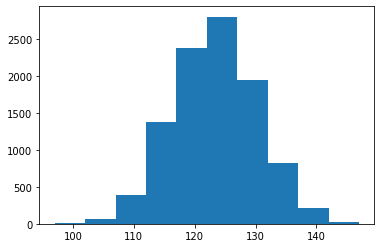

In [164]:
glove_result4 = generate_dist(glove_exp_dict4, 10000)
plt.hist(glove_result4)
plt.show()

In [165]:
print(mean_confidence_interval(glove_result4, confidence=0.95))
print(mean_confidence_interval(glove_result4, confidence=0.95)[0]/len(glove_exp_dict4.keys()))
print(len(glove_exp_dict4.keys()))

(122.8714, 122.73743959264065, 123.00536040735933)
0.36787844311377244
334


In [56]:
sk_exp_dict4 = generate_dict('Positive_word-list', 60, np_embed, sk_word_to_ix, sk_ix_to_word)

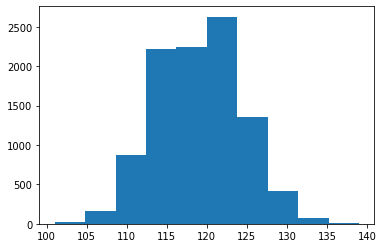

In [166]:
sk_result4 = generate_dist(sk_exp_dict4,10000)
plt.hist(sk_result4)
plt.show()

In [167]:
print(mean_confidence_interval(sk_result4, confidence=0.95))
print(mean_confidence_interval(sk_result4, confidence=0.95)[0]/len(sk_exp_dict4.keys()))
print(len(sk_exp_dict4.keys()))

(118.8691, 118.76869140187362, 118.96950859812638)
0.3558955089820359
334


In [57]:
cb_exp_dict4 = generate_dict('Positive_word-list', 60, cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [72]:
glove_result4 = generate_dist(glove_exp_dict4,10000)
sk_result4 = generate_dist(sk_exp_dict4,10000)
cb_result4 = generate_dist(cb_exp_dict4,10000)

In [168]:
# For positive: glove is better
test_proportion(0.3558955089820359,0.36787844311377244, 10000)

Sample size required for alpha = 0.05, power = 0.8:  19882.67629786787
With all the available sample, the power we can achieved is: 0.3641547198710897
T test statistic -1.7632459423774787
P value 0.08429298266392453


### Superfluous

In [58]:
glove_exp_dict5 = generate_dict('Superfluous_word-list', 60, glove_embedding, gl_word_to_ix, gl_ix_to_word)

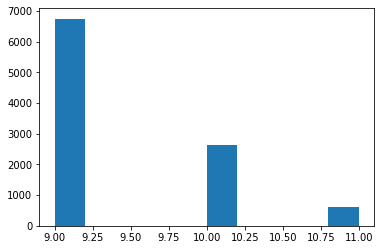

In [169]:
glove_result5 = generate_dist(glove_exp_dict5,10000)
plt.hist(glove_result5)
plt.show()

In [170]:
print(mean_confidence_interval(glove_result5, confidence=0.95))
print(mean_confidence_interval(glove_result5, confidence=0.95)[0]/len(glove_exp_dict5.keys()))
print(len(glove_exp_dict5.keys()))

(9.386, 9.374247944499905, 9.397752055500094)
0.22892682926829266
41


In [59]:
sk_exp_dict5 = generate_dict('Superfluous_word-list', 60, np_embed, sk_word_to_ix, sk_ix_to_word)

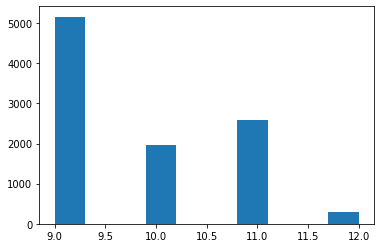

In [171]:
sk_result5 = generate_dist(sk_exp_dict5,10000)
plt.hist(sk_result5)
plt.show()

In [172]:
print(mean_confidence_interval(sk_result5, confidence=0.95))
print(mean_confidence_interval(sk_result5, confidence=0.95)[0]/len(sk_exp_dict5.keys()))
print(len(sk_exp_dict5.keys()))

(9.7999, 9.78183905738731, 9.817960942612688)
0.23902195121951217
41


In [60]:
cb_exp_dict5 = generate_dict('Superfluous_word-list', 60, cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [73]:
glove_result5 = generate_dist(glove_exp_dict5,10000)
sk_result5 = generate_dist(sk_exp_dict5,10000)
cb_result5 = generate_dist(cb_exp_dict5,10000)

In [173]:
# For superfluous: our model is better
test_proportion(0.22892682926829266,0.23902195121951217, 10000)

Sample size required for alpha = 0.05, power = 0.8:  21743.27080882024
With all the available sample, the power we can achieved is: 0.406509758988148
T test statistic -1.6861288727399326
P value 0.09628393264836914


### Uncertainty

In [61]:
glove_exp_dict6 = generate_dict('Uncertainty_word-list', 60, glove_embedding, gl_word_to_ix, gl_ix_to_word)

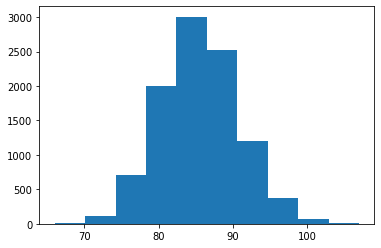

In [176]:
glove_result6 = generate_dist(glove_exp_dict6,10000)
plt.hist(glove_result6)
plt.show()

In [177]:
print(mean_confidence_interval(glove_result6, confidence=0.95))
print(mean_confidence_interval(glove_result6, confidence=0.95)[0]/len(glove_exp_dict6.keys()))
print(len(glove_exp_dict6.keys()))

(85.5259, 85.42508699150602, 85.62671300849397)
0.3302158301158301
259


In [62]:
sk_exp_dict6 = generate_dict('Uncertainty_word-list', 60, np_embed, sk_word_to_ix, sk_ix_to_word)

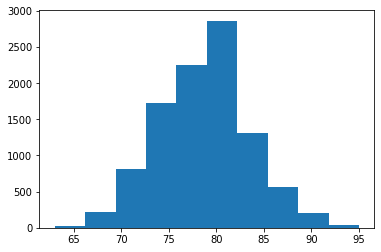

In [179]:
sk_result6 = generate_dist(sk_exp_dict6,10000)
plt.hist(sk_result6)
plt.show()

In [180]:
print(mean_confidence_interval(sk_result6, confidence=0.95))
print(mean_confidence_interval(sk_result6, confidence=0.95)[0]/len(sk_exp_dict6.keys()))
print(len(glove_exp_dict6.keys()))

(78.5817, 78.48675121892985, 78.67664878107014)
0.30340424710424707
259


In [63]:
cb_exp_dict6 = generate_dict('Uncertainty_word-list', 60, cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [74]:
glove_result6 = generate_dist(glove_exp_dict6,10000)
sk_result6 = generate_dist(sk_exp_dict6,10000)
cb_result6 = generate_dist(cb_exp_dict6,10000)

In [181]:
# For uncertainty: glove is better
test_proportion(0.30340424710424707,0.3302158301158301, 10000)

Sample size required for alpha = 0.05, power = 0.8:  3719.9138883148416
T test statistic -4.075090454489035
P value 9.882898366099615e-05


### Example

In [318]:
'deviates' in d['Uncertainty_word-list']

True

In [395]:
import json

In [392]:
new_d = dict()
for key, value in sk_exp_dict6.items():
#     print(key,value)
    new_d[key] = list(zip(*value))[0][:20]

In [396]:
json.dump(new_d, open("myfile.json", 'w'))

In [389]:
sk_exp_dict6['uncertainty']

[('uncertainty', 0.99999994),
 ('considerable', 0.74531835),
 ('challenges', 0.73779625),
 ('uncertainties', 0.73413485),
 ('interpretation', 0.7311586),
 ('surrounding', 0.7276919),
 ('political', 0.71895593),
 ('developments', 0.71620923),
 ('predicting', 0.701116),
 ('uncertain', 0.6976521),
 ('interplay', 0.697446),
 ('changing', 0.69587564),
 ('linguistic', 0.6871569),
 ('nature', 0.6847816),
 ('legislative', 0.6815719),
 ('undoubtedly', 0.68110675),
 ('ramifications', 0.6807187),
 ('significant', 0.6728511),
 ('complexity', 0.6726919),
 ('complex', 0.6713226),
 ('turbulence', 0.67021114),
 ('evolution', 0.6679671),
 ('implications', 0.6668882),
 ('environment', 0.6638985),
 ('landscape', 0.6633279),
 ('challenging', 0.66289645),
 ('belief', 0.66196555),
 ('persistence', 0.6619444),
 ('turbulent', 0.6568282),
 ('controversy', 0.656255),
 ('possibilities', 0.6552987),
 ('particularly', 0.65429485),
 ('ambiguity', 0.6533522),
 ('evolving', 0.6513058),
 ('economic', 0.65084094),
 ('a

In [242]:
for i in [cb_result1,cb_result2,cb_result3,cb_result4,cb_result5,cb_result6]:
    print(np.mean(i))

0.0
214.1262
986.1888
130.0072
9.7877
90.8751


In [232]:
for key,value in d.items():
    print(len(value))

171
63
517
1933
334
41
259


In [75]:
glove_result_ls = [glove_result0,glove_result1,glove_result2,glove_result3,glove_result4,glove_result5,glove_result6]
sk_result_ls = [sk_result0,sk_result1,sk_result2,sk_result3,sk_result4,sk_result5,sk_result6]
cb_result_ls = [cb_result0,cb_result1,cb_result2,cb_result3,cb_result4,cb_result5,cb_result6]
length_ls = [171,63,517,1933,334,41,259]

In [76]:
mean_gl = []
std_gl = []
mean_sk = []
std_sk = []
mean_cb = []
std_cb = []
for ele in list(zip(glove_result_ls,sk_result_ls,cb_result_ls,length_ls)):
    mean_gl.append(np.mean(ele[0])/ele[3]*100)
    std_gl.append(np.std(ele[0])/ele[3]*100)
    mean_sk.append(np.mean(ele[1])/ele[3]*100)
    std_sk.append(np.std(ele[1])/ele[3]*100)
    mean_cb.append(np.mean(ele[2])/ele[3]*100)
    std_cb.append(np.std(ele[2])/ele[3]*100)

In [79]:
length = [171,63,517,1933,334,41,259]
labels = ['Constraining','Interesting','Litigious','Negative','Positive','Superfluous','Uncertainty']

In [80]:
length,labels,mean_gl,std_gl,mean_sk,std_sk,mean_cb,std_cb = list(zip(*sorted(list(zip(length,labels,mean_gl,std_gl,mean_sk,std_sk,mean_cb,std_cb)),key=lambda x: x[0],reverse=True)))

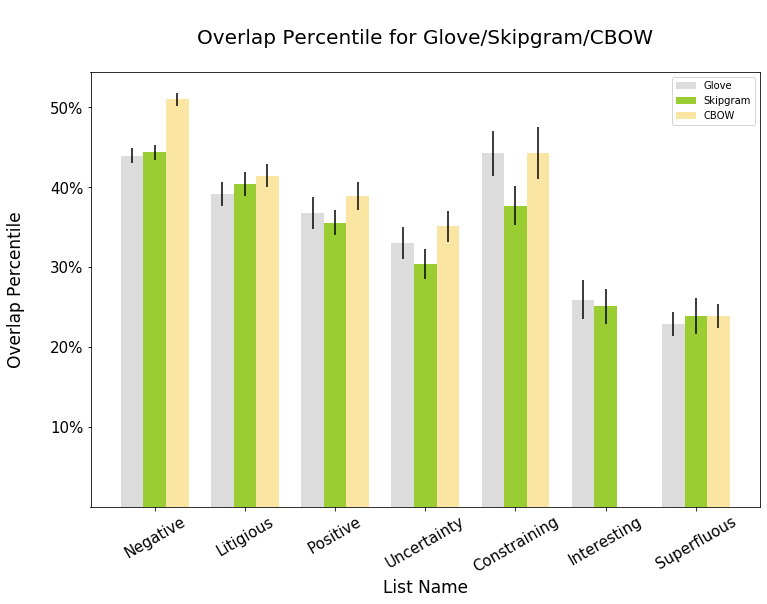

In [81]:
# labels = ['Constraining','Interesting','Litigious','Negative','Positive','Superfluous','Uncertainty']


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x - 3*width/3, mean_gl,width, yerr=std_gl, color='gainsboro', label='Glove')
rects2 = ax.bar(x, mean_sk, width, yerr=std_sk, color = 'yellowgreen', label='Skipgram')
rects3 = ax.bar(x + 3*width/3, mean_cb, width, yerr=std_cb, color = '#fbe5a3', label='CBOW')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Overlap Percentile\n',size=17)
ax.set_xlabel('List Name',size=17)
ax.set_title('\nOverlap Percentile for Glove/Skipgram/CBOW\n',size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=30,size=15)
ax.set_yticks([10,20,30,40,50])
ax.set_yticklabels(['10%','20%','30%','40%','50%'],size=15)
ax.legend()

# fig.tight_layout()

plt.show()

In [517]:
mean_cb

[44.227660818713446,
 0.0,
 41.41705996131528,
 51.01856182100363,
 38.924311377245516,
 23.87243902439024,
 35.086911196911196]

In [518]:
std_cb

[1.0152229953810688e-05,
 6.597037109398804e-05,
 2.7854385147723824e-06,
 1.9304388549153808e-06,
 3.7919041449641745e-06,
 3.097037493272757e-05,
 7.440631317298715e-06]

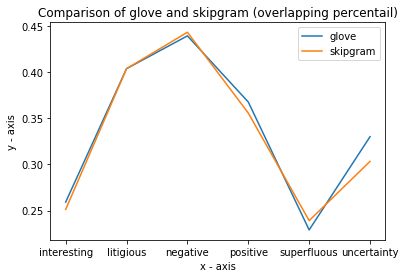

In [6]:
x1 = ['interesting','litigious','negative','positive','superfluous','uncertainty']
y1 = glove_p
plt.bar(x1, y, label = "glove")
x2 = x1
y2 = sk_p
plt.bar(x2, y2, label = "skipgram")
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Comparison of glove and skipgram (overlapping percentail)')
plt.legend()
plt.show()

# Another way to expend-from centroid

## Without bootstrap

In [64]:
d.keys()

dict_keys(['Constraining_word-list', 'Interesting_word-list', 'Litigious_word-list', 'Negative_word-list', 'Positive_word-list', 'Superfluous_word-list', 'Uncertainty_word-list'])

In [82]:
def generate_dict2(name,embedding,word_to_ix,ix_to_word):
    top = len(d[name])
    similarity_list = []
    
    count = 0
    embed_sum = 0
    for word in d[name]:
        try:
            word_idx = word_to_ix[word]
            embed_sum += embedding[word_idx]
            count += 1
        except KeyError:
            continue
#     print(count)
    centroid = embed_sum/count
    similarities = cosine_similarity(centroid.reshape(1,50), embedding).reshape(-1,)
    similarities_l = similarities.argsort()[-top:].reshape(-1,)
    
    for ix in similarities_l[::-1]:
        similarity_list.append((ix_to_word[ix],similarities[ix]))
    return similarity_list

In [83]:
ls_sk1 = generate_dict2('Interesting_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_gl1 = generate_dict2('Interesting_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
c_sk1 = len(set(list(zip(*ls_sk1))[0]).intersection(set(d['Interesting_word-list'])))
c_gl1 = len(set(list(zip(*ls_gl1))[0]).intersection(set(d['Interesting_word-list'])))
length1 = len(d['Interesting_word-list'])
p_sk1 = round(c_sk1/length1*100,2)
p_gl1 = round(c_gl1/length1*100,2)
print(f"Interesting list overlap: Skipgram:{c_sk1} ({p_sk1}%) Glove:{c_gl1} ({p_gl1}%),Length of word list:{length1}")

Interesting list overlap: Skipgram:1 (1.59%) Glove:2 (3.17%),Length of word list:63


In [84]:
ls_sk2 = generate_dict2('Constraining_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_gl2 = generate_dict2('Constraining_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
c_sk2 = len(set(list(zip(*ls_sk2))[0]).intersection(set(d['Constraining_word-list'])))
c_gl2 = len(set(list(zip(*ls_gl2))[0]).intersection(set(d['Constraining_word-list'])))
length2 = len(d['Constraining_word-list'])
p_sk2 = round(c_sk2/length2*100,2)
p_gl2 = round(c_gl2/length2*100,2)
print(f"Constraining list overlap: Skipgram:{c_sk2} ({p_sk2}%) Glove:{c_gl2} ({p_gl2}%),Length of word list:{length2}")

Constraining list overlap: Skipgram:46 (26.9%) Glove:56 (32.75%),Length of word list:171


In [85]:
ls_sk3 = generate_dict2('Litigious_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_gl3 = generate_dict2('Litigious_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
c_sk3 = len(set(list(zip(*ls_sk3))[0]).intersection(set(d['Litigious_word-list'])))
c_gl3 = len(set(list(zip(*ls_gl3))[0]).intersection(set(d['Litigious_word-list'])))
length3 = len(d['Litigious_word-list'])
p_sk3 = round(c_sk3/length3*100,2)
p_gl3 = round(c_gl3/length3*100,2)
print(f"Litigious list overlap: Skipgram:{c_sk3} ({p_sk3}%) Glove:{c_gl3} ({p_gl3}%),Length of word list:{length3}")

Litigious list overlap: Skipgram:150 (29.01%) Glove:154 (29.79%),Length of word list:517


In [86]:
ls_sk4 = generate_dict2('Negative_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_gl4 = generate_dict2('Negative_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
c_sk4 = len(set(list(zip(*ls_sk4))[0]).intersection(set(d['Negative_word-list'])))
c_gl4 = len(set(list(zip(*ls_gl4))[0]).intersection(set(d['Negative_word-list'])))
length4 = len(d['Negative_word-list'])
p_sk4 = round(c_sk4/length4*100,2)
p_gl4 = round(c_gl4/length4*100,2)
print(f"Negative list overlap: Skipgram:{c_sk4} ({p_sk4}%) Glove:{c_gl4} ({p_gl4}%),Length of word list:{length4}")

Negative list overlap: Skipgram:671 (34.71%) Glove:634 (32.8%),Length of word list:1933


In [87]:
ls_sk5 = generate_dict2('Positive_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_gl5 = generate_dict2('Positive_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
c_sk5 = len(set(list(zip(*ls_sk5))[0]).intersection(set(d['Positive_word-list'])))
c_gl5 = len(set(list(zip(*ls_gl5))[0]).intersection(set(d['Positive_word-list'])))
length5 = len(d['Positive_word-list'])
p_sk5 = round(c_sk5/length5*100,2)
p_gl5 = round(c_gl5/length5*100,2)
print(f"Positive list overlap: Skipgram:{c_sk5} ({p_sk5}%) Glove:{c_gl5} ({p_gl5}%),Length of word list:{length5}")

Positive list overlap: Skipgram:62 (18.56%) Glove:60 (17.96%),Length of word list:334


In [88]:
ls_sk6 = generate_dict2('Superfluous_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_gl6 = generate_dict2('Superfluous_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
c_sk6 = len(set(list(zip(*ls_sk6))[0]).intersection(set(d['Superfluous_word-list'])))
c_gl6 = len(set(list(zip(*ls_gl6))[0]).intersection(set(d['Superfluous_word-list'])))
length6 = len(d['Superfluous_word-list'])
p_sk6 = round(c_sk6/length6*100,2)
p_gl6 = round(c_gl6/length6*100,2)
print(f"Superfluous list overlap: Skipgram:{c_sk6} ({p_sk6}%) Glove:{c_gl6} ({p_gl6}%),Length of word list:{length6}")

Superfluous list overlap: Skipgram:0 (0.0%) Glove:1 (2.44%),Length of word list:41


In [89]:
ls_sk7 = generate_dict2('Uncertainty_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_gl7 = generate_dict2('Uncertainty_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
c_sk7 = len(set(list(zip(*ls_sk7))[0]).intersection(set(d['Uncertainty_word-list'])))
c_gl7 = len(set(list(zip(*ls_gl7))[0]).intersection(set(d['Uncertainty_word-list'])))
length7 = len(d['Uncertainty_word-list'])
p_sk7 = round(c_sk7/length7*100,2)
p_gl7 = round(c_gl7/length7*100,2)
print(f"Uncertainty list overlap: Skipgram:{c_sk7} ({p_sk7}%) Glove:{c_gl7} ({p_gl7}%),Length of word list:{length7}")

Uncertainty list overlap: Skipgram:29 (11.2%) Glove:38 (14.67%),Length of word list:259


In [90]:
p_sk = [p_sk1,p_sk2,p_sk3,p_sk4,p_sk5,p_sk6,p_sk7]
p_gl = [p_gl1,p_gl2,p_gl3,p_gl4,p_gl5,p_gl6,p_gl7]
c_sk = [c_sk1,c_sk2,c_sk3,c_sk4,c_sk5,c_sk6,c_sk7]
c_gl = [c_gl1,c_gl2,c_gl3,c_gl4,c_gl5,c_gl6,c_gl7]

In [336]:
df_exp_centroid = pd.DataFrame({'skipgram(%)':p_sk,
                                'glove(%)':p_gl,
                                'skipgram count':c_sk,
                                'glove count':c_gl})

In [337]:
df_exp_centroid

,skipgram(%),glove(%),skipgram count,glove count
0,1.59,3.17,1,2
1,26.90,32.75,46,56
2,29.01,29.79,150,154
3,34.71,32.80,671,634
4,18.56,17.96,62,60
5,0.00,2.44,0,1
6,11.20,14.67,29,38


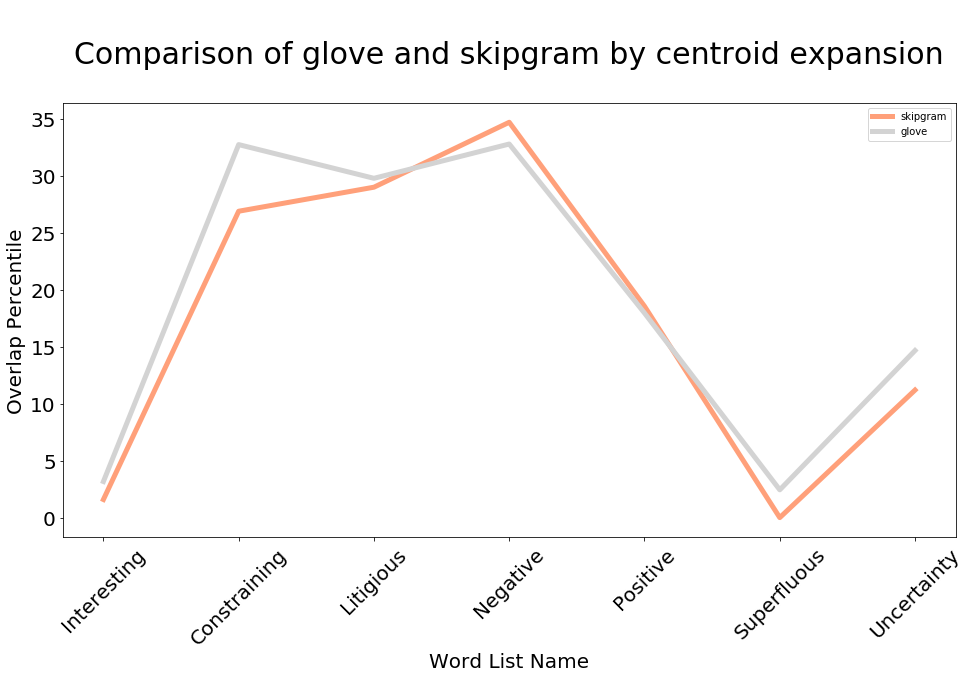

In [264]:
x1 = ['Interesting','Constraining','Litigious','Negative','Positive','Superfluous','Uncertainty']
y1 = df_exp_centroid['skipgram(%)']
plt.figure(figsize=(16.0,8.0))
plt.plot(x1, y1, label = "skipgram",color='lightsalmon',linewidth=5)
x2 = x1
y2 = df_exp_centroid['glove(%)']
plt.plot(x2, y2, label = "glove",color='lightgrey',linewidth=5)
plt.xlabel('Word List Name',size=20)
plt.ylabel('Overlap Percentile',size=20)
plt.xticks(rotation=45,size=20)
plt.yticks(size=20)
plt.title('\nComparison of glove and skipgram by centroid expansion\n',size=30)
plt.legend()
plt.show()

In [ ]:
# bar graph order by list length

## With bootstrap

In [95]:
def generate_dict3(n,name,embedding,word_to_ix,ix_to_word):
    top = len(d[name])
    count_ls = []
    for i in range(n):
        similarity_list = []
        sample = random.sample(d[name],int(top*0.22))
        count = 0
        embed_sum = 0
        for word in sample:
            try:
                word_idx = word_to_ix[word]
                embed_sum += embedding[word_idx]
                count += 1
            except KeyError:
                continue
    #     print(count)
        centroid = embed_sum/count
#         print(centroid)
        similarities = cosine_similarity(centroid.reshape(1,50), embedding).reshape(-1,)
        similarities_l = similarities.argsort()[-top:].reshape(-1,)
        for ix in similarities_l[::-1]:
#             similarity_list.append((ix_to_word[ix],similarities[ix]))
            similarity_list.append(ix_to_word[ix])
#         print(similarity_list[:10])
        c = len(set(similarity_list).intersection(d[name]))
        count_ls.append(c)
    return count_ls

In [386]:
sample = generate_dict3(1,'Uncertainty_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)

[ 0.5404245  -0.40357068 -0.03837774 -0.16676894 -0.17911784  0.3055439
  0.10672992  0.11295075  0.15237978  0.46030968  0.30054998 -0.0064265
  0.06615562 -0.05799754  0.24975331  0.42536116  0.04988381  0.01323509
  0.04236827 -0.5365323  -0.03534969 -0.35284898  0.02594434 -0.00799431
  0.32259467 -0.317255   -0.40562707  0.10879971  0.5316585   0.20657603
  1.1869409   0.09491245  0.06253015 -0.6165322   0.33500168 -0.1225968
 -0.29736495  0.1265627  -0.05849565 -0.27283978 -0.4030399  -0.1993854
  0.36080882  0.5327352  -0.1362203  -0.04555321  0.09410637  0.3568693
  0.01530576  0.10558223]
['difficult', 'predicted', 'magnitude', 'quite', 'rapidly', 'obviously', 'definitely', 'given', 'complexity', 'albeit']


In [103]:
ls_wsk0 = generate_dict3(500,'Constraining_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_wgl0 = generate_dict3(500,'Constraining_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
ls_wcb0 = generate_dict3(500,'Constraining_word-list',cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [96]:
ls_wsk1 = generate_dict3(500,'Interesting_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_wgl1 = generate_dict3(500,'Interesting_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
ls_wcb1 = generate_dict3(500,'Interesting_word-list',cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [97]:
ls_wsk2 = generate_dict3(500,'Litigious_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_wgl2 = generate_dict3(500,'Litigious_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
ls_wcb2 = generate_dict3(500,'Litigious_word-list',cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [98]:
ls_wsk3 = generate_dict3(500,'Negative_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_wgl3 = generate_dict3(500,'Negative_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
ls_wcb3 = generate_dict3(500,'Negative_word-list',cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [99]:
ls_wsk4 = generate_dict3(500,'Positive_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_wgl4 = generate_dict3(500,'Positive_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
ls_wcb4 = generate_dict3(500,'Positive_word-list',cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [100]:
ls_wsk5 = generate_dict3(500,'Superfluous_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_wgl5 = generate_dict3(500,'Superfluous_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
ls_wcb5 = generate_dict3(500,'Superfluous_word-list',cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [101]:
ls_wsk6 = generate_dict3(500,'Uncertainty_word-list',np_embed, sk_word_to_ix, sk_ix_to_word)
ls_wgl6 = generate_dict3(500,'Uncertainty_word-list',glove_embedding, gl_word_to_ix, gl_ix_to_word)
ls_wcb6 = generate_dict3(500,'Uncertainty_word-list',cbow_embed, cb_word_to_ix, cb_ix_to_word)

In [104]:
ls_wsk = [ls_wsk0,ls_wsk1,ls_wsk2,ls_wsk3,ls_wsk4,ls_wsk5,ls_wsk6]
ls_wgl = [ls_wgl0,ls_wgl1,ls_wgl2,ls_wgl3,ls_wgl4,ls_wgl5,ls_wgl6]
ls_wcb = [ls_wcb0,ls_wcb1,ls_wcb2,ls_wcb3,ls_wcb4,ls_wcb5,ls_wcb6]
length_ls = [171,63,517,1933,334,41,259]

In [105]:
mean_glc = []
std_glc = []
mean_skc = []
std_skc = []
mean_cbc = []
std_cbc = []
for ele in list(zip(ls_wsk,ls_wgl,ls_wcb,length_ls)):
    mean_glc.append(np.mean(ele[1])/ele[3]*100)
    std_glc.append(np.std(ele[1])/ele[3]*100)
    mean_skc.append(np.mean(ele[0])/ele[3]*100)
    std_skc.append(np.std(ele[0])/ele[3]*100)
    mean_cbc.append(np.mean(ele[2])/ele[3]*100)
    std_cbc.append(np.std(ele[2])/ele[3]*100)

In [ ]:
length,labels,mean_glc,std_glc,mean_skc,std_skc,mean_cbc,std_cbc = list(zip(*sorted(list(zip(length,labels,mean_gl,std_gl,mean_sk,std_sk,mean_cb,std_cb)),key=lambda x: x[0],reverse=True)))

In [ ]:
# labels = ['Constraining','Interesting','Litigious','Negative','Positive','Superfluous','Uncertainty']


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))

rects1 = ax.bar(x - 3*width/3, mean_gl,width, yerr=std_gl, color='gainsboro', label='Glove')
rects2 = ax.bar(x, mean_sk, width, yerr=std_sk, color = 'yellowgreen', label='Skipgram')
rects3 = ax.bar(x + 3*width/3, mean_cb, width, yerr=std_cb, color = '#fbe5a3', label='CBOW')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Overlap Percentile\n',size=17)
ax.set_xlabel('List Name',size=17)
ax.set_title('\nOverlap Percentile for Glove/Skipgram/CBOW\n',size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=30,size=15)
ax.set_yticks([10,20,30,40,50])
ax.set_yticklabels(['10%','20%','30%','40%','50%'],size=15)
ax.legend()

# fig.tight_layout()

plt.show()

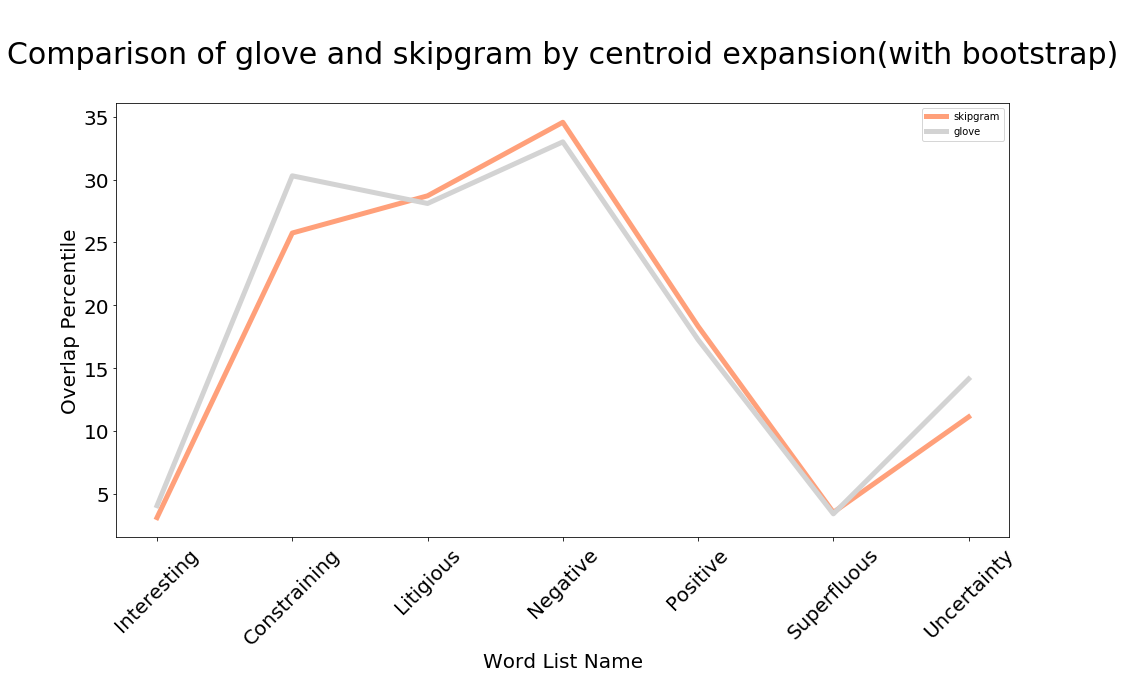

In [265]:
x1 = ['Interesting','Constraining','Litigious','Negative','Positive','Superfluous','Uncertainty']
y1 = p_wsk
plt.figure(figsize=(16.0,8.0))
plt.plot(x1, y1, label = "skipgram",color='lightsalmon',linewidth=5)
y2 = p_wgl
plt.plot(x1, y2, label = "glove",color='lightgrey',linewidth=5)
plt.xlabel('Word List Name',size=20)
plt.ylabel('Overlap Percentile',size=20)
plt.xticks(rotation=45,size=20)
plt.yticks(size=20)
plt.title('\nComparison of glove and skipgram by centroid expansion(with bootstrap)\n',size=30)
plt.legend()
plt.show()

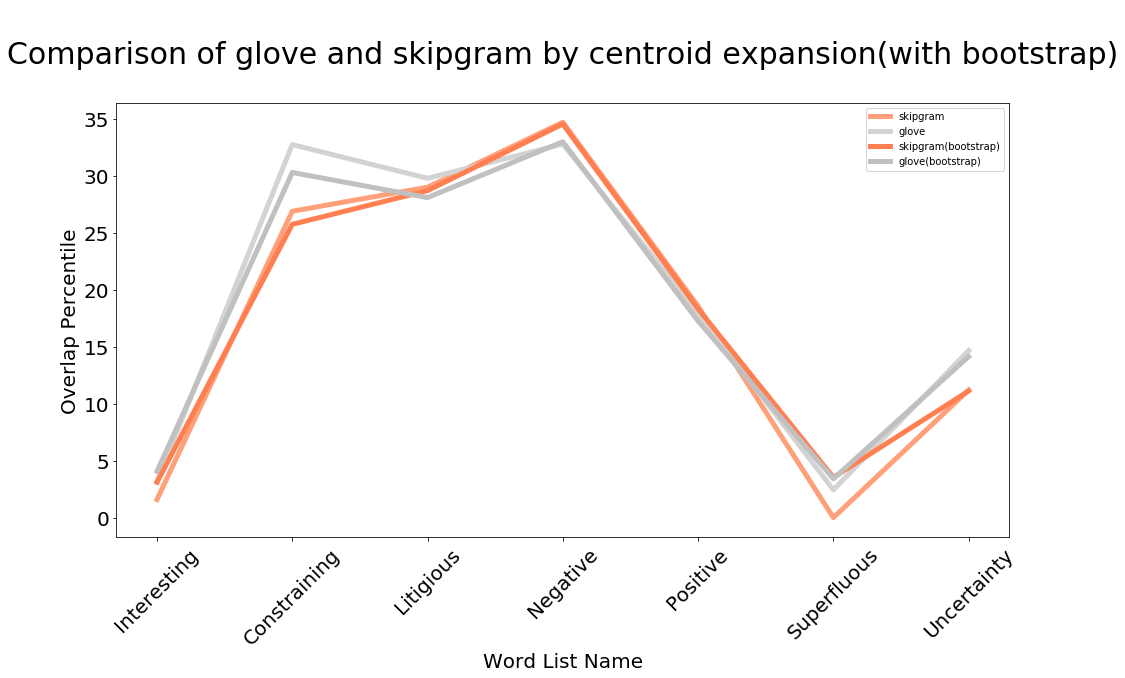

In [266]:
x1 = ['Interesting','Constraining','Litigious','Negative','Positive','Superfluous','Uncertainty']
y1 = p_sk
y2 = p_gl
y3 = p_wsk
y4 = p_wgl
plt.figure(figsize=(16.0,8.0))
plt.plot(x1, y1, label = "skipgram",color='lightsalmon',linewidth=5)
plt.plot(x1, y2, label = "glove",color='lightgrey',linewidth=5)
plt.plot(x1, y3, label = "skipgram(bootstrap)",color='coral',linewidth=5)
plt.plot(x1, y4, label = "glove(bootstrap)",color='silver',linewidth=5)
plt.xlabel('Word List Name',size=20)
plt.ylabel('Overlap Percentile',size=20)
plt.xticks(rotation=45,size=20)
plt.yticks(size=20)
plt.title('\nComparison of glove and skipgram by centroid expansion(with bootstrap)\n',size=30)
plt.legend()
plt.show()

# Frequency

## 

In [321]:
biglist = pd.read_csv("/ifs/gsb/usf_interns/LM_word_lists/LoughranMcDonald_MasterDictionary_2018.csv")

In [322]:
biglist.columns

Index(['Word', 'Sequence Number', 'Word Count', 'Word Proportion',
       'Average Proportion', 'Std Dev', 'Doc Count', 'Negative', 'Positive',
       'Uncertainty', 'Litigious', 'Constraining', 'Superfluous',
       'Interesting', 'Modal', 'Irr_Verb', 'Harvard_IV', 'Syllables',
       'Source'],
      dtype='object')

In [323]:
biglist.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
0,AARDVARK,1,277,1.480000e-08,1.240000e-08,3.560000e-06,84,0,0,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.600000e-10,9.730000e-12,9.860000e-09,1,0,0,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,8,4.280000e-10,1.390000e-10,6.230000e-08,7,0,0,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,12,6.410000e-10,3.160000e-10,9.380000e-08,12,0,0,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,7250,3.870000e-07,3.680000e-07,3.370000e-05,914,0,0,0,0,0,0,0,0,0,0,3,12of12inf


In [324]:
word_from_master_dict = []
for w in list(biglist['Word'].values):
    try:
        word_from_master_dict.append(w.lower())
    except AttributeError:
        word_from_master_dict.append(w)
freq_from_master_dict = list(biglist['Average Proportion'].values)
freq_d = dict(zip(word_from_master_dict,freq_from_master_dict))

In [319]:
def freq_gl_sk_compare(glove_dict,sk_dict,name):
    """Calculate frequency without bootstrap"""
    count = []
    common = []
    sk_set = set()
    gl_set = set()
    # Find and exclude common word
    for (k1,v1), (k2,v2) in zip(glove_dict.items(), sk_dict.items()):
        share = set(list(zip(*v1))[0]).intersection(list(zip(*v2))[0])
        sk_set = sk_set.union(list(set(list(zip(*v1))[0])-share))
        gl_set = gl_set.union(list(set(list(zip(*v2))[0])-share))  
        c = len(share)
        common.append(share)
        count.append(c)
    average_overlap_p = round(np.mean(count)/len(list(glove_dict.keys()))*100)
    plt.hist(count)
    plt.title(f"Histogram of {name} Word List")
    plt.xlabel(f"Average Overlapping Percentage is {average_overlap_p}%")
#     plt.vlines(x = np.mean(count),ymin=0,ymax=np.max(count),color = 'red')
    plt.show()
    
    freq_sk = []
    for w in list(sk_set):
        try:
            freq_sk.append(freq_d[w])
        except KeyError:
            freq_sk.append("N/A")
    freq_gl = []
    for w in list(gl_set):
        try:
            freq_gl.append(freq_d[w])
        except KeyError:
            freq_gl.append("N/A")
#     sk_p = np.percentile(a = [freq for freq in freq_sk if freq!= 'N/A'],q = [5,20,25,50,75,90,95] )
#     gl_p = np.percentile(a = [freq for freq in freq_gl if freq!= 'N/A'],q = [5,20,25,50,75,90,95] )
#     return freq_sk,freq_gl,count
    return freq_sk,freq_gl,count,sk_set, gl_set,common

In [298]:
def calculate_mean_std(freq_sk,freq_gl):
    count = 0
    freq_sk_new = []
    freq_gl_new = []
    for f in freq_sk:
        if f!='N/A':
            count += 1
            freq_sk_new.append(f)
    print(count)
    count = 0
    for f in freq_gl:
        if f!='N/A':
            count += 1
            freq_gl_new.append(f)
    print(count)
    mean_sk = np.mean(freq_sk_new)
    std_sk = np.std(freq_sk_new)
    mean_gl = np.mean(freq_gl_new)
    std_gl = np.std(freq_gl_new)
    # print(mean_sk,std_sk,mean_gl,std_gl)
    return mean_sk,std_sk,mean_gl,std_gl

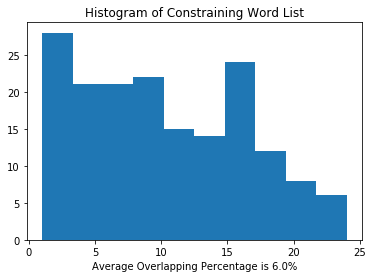

In [299]:
freq_sk0,freq_gl0,count0 = freq_gl_sk_compare(glove_exp_dict0,sk_exp_dict0,'Constraining')

In [300]:
mean_sk0,std_sk0,mean_gl0,std_gl0 = calculate_mean_std(freq_sk0,freq_gl0)

3740
3949


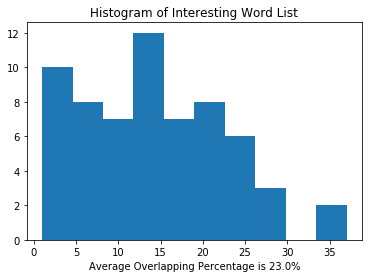

In [301]:
freq_sk1,freq_gl1,count1 = freq_gl_sk_compare(glove_exp_dict1,sk_exp_dict1,'Interesting')

In [302]:
mean_sk1,std_sk1,mean_gl1,std_gl1 = calculate_mean_std(freq_sk1,freq_gl1)

1982
2088


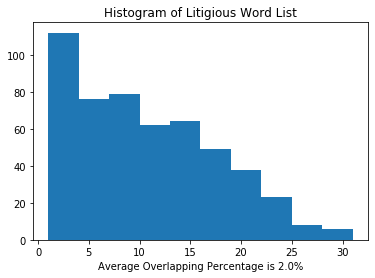

In [303]:
freq_sk2,freq_gl2,count2 = freq_gl_sk_compare(glove_exp_dict2,sk_exp_dict2,'Litigious')

In [304]:
mean_sk2,std_sk2,mean_gl2,std_gl2 = calculate_mean_std(freq_sk2,freq_gl2)

7610
6759


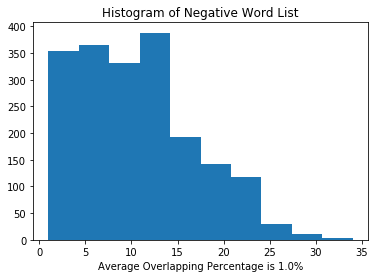

In [305]:
freq_sk3,freq_gl3,count3 = freq_gl_sk_compare(glove_exp_dict3,sk_exp_dict3,'Negative')

In [306]:
mean_sk3,std_sk3,mean_gl3,std_gl3 = calculate_mean_std(freq_sk3,freq_gl3)

20700
16446


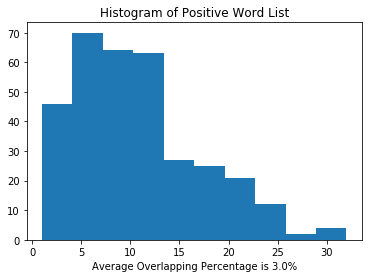

In [307]:
freq_sk4,freq_gl4,count4 = freq_gl_sk_compare(glove_exp_dict4,sk_exp_dict4,'Positive')

In [308]:
mean_sk4,std_sk4,mean_gl4,std_gl4 = calculate_mean_std(freq_sk4,freq_gl4)

6697
6029


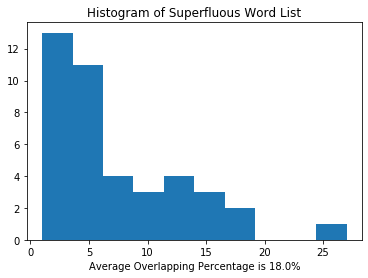

In [309]:
freq_sk5,freq_gl5,count5 = freq_gl_sk_compare(glove_exp_dict5,sk_exp_dict5,'Superfluous')

In [310]:
mean_sk5,std_sk5,mean_gl5,std_gl5 = calculate_mean_std(freq_sk5,freq_gl5)

1253
1485


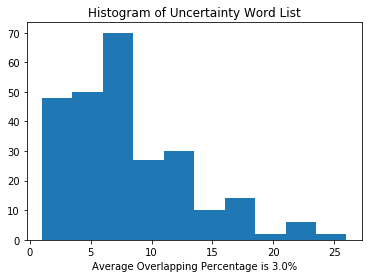

In [323]:
freq_sk6,freq_gl6,count6,sk_set6, gl_set6, common = freq_gl_sk_compare(glove_exp_dict6,sk_exp_dict6,'Uncertainty')

In [321]:
mean_sk6,std_sk6,mean_gl6,std_gl6 = calculate_mean_std(freq_sk6,freq_gl6)

6164
6026


In [313]:
mean_sk = [mean_sk0,mean_sk1,mean_sk2,mean_sk3,mean_sk4,mean_sk5,mean_sk6]
mean_gl = [mean_gl0,mean_gl1,mean_gl2,mean_gl3,mean_gl4,mean_gl5,mean_gl6]
std_sk = [std_sk0,std_sk1,std_sk2,std_sk3,std_sk4,std_sk5,std_sk6]
std_gl = [std_gl0,std_gl1,std_gl2,std_gl3,std_gl4,std_gl5,std_gl6]

In [314]:
mean_std = pd.DataFrame({'skipgram mean':mean_sk,
                         'glove mean':mean_gl,
                         'skipgram std':std_sk,
                         'glove std':std_gl})
mean_std

,skipgram mean,glove mean,skipgram std,glove std
0,0.000067,0.000039,0.000660,0.000241
1,0.000134,0.000046,0.002076,0.000305
2,0.000034,0.000024,0.000302,0.000139
3,0.000030,0.000021,0.000370,0.000149
4,0.000087,0.000034,0.001276,0.000209
5,0.000065,0.000018,0.001123,0.000109
6,0.000067,0.000037,0.000732,0.000223


### What are those words?

In [324]:
common

[{'abeyance', 'amicably', 'appellant', 'receivership', 'sequestered'},
 {'alteration',
  'irreversible',
  'modification',
  'necessitated',
  'necessitating'},
 {'alterations', 'necessitated', 'renovations', 'repairs', 'undergoing'},
 {'ambiguities',
  'ambiguity',
  'broach',
  'caveats',
  'contradictions',
  'inaccuracies',
  'justifications',
  'presumptions',
  'vagueness'},
 {'ambiguities',
  'ambiguity',
  'ambiguous',
  'complexities',
  'contradiction',
  'contradictions',
  'illegality',
  'obvious',
  'ramifications',
  'seriousness',
  'vagueness'},
 {'ambiguity',
  'ambiguous',
  'contradictory',
  'implication',
  'interpretation',
  'interpreted',
  'vague',
  'wording'},
 {'abnormalities',
  'abnormality',
  'anomalies',
  'anomalous',
  'anomaly',
  'chromosomal',
  'climatic',
  'collisions',
  'deviations',
  'hypothesized',
  'macroscopic',
  'severity'},
 {'anomalies',
  'anomalous',
  'anomaly',
  'asymmetry',
  'attenuation',
  'causal',
  'climatic',
  'deleter

In [338]:
print(sk_set6)

{'abandonment', 'timeliness', 'comprehensible', 'overt', 'explanation', 'abdicating', 'malady', 'sequence', 'emergency', 'stalwartly', 'omitted', 'sufficient', 'oblivious', 'isles', 'succeeded', 'withdrawal', 'previous', 'karyotypes', 'suspension', 'refuse', 'lawful', 'harbingers', 'proper', 'inferring', 'masked', 'vary', 'cryptic', 'recognized', 'cautioning', 'army', 'illogic', 'mishearing', 'rust-colored', 'verged', 'oodles', 'skirmish', 'deviates', 'corroborated', 'permits', 'spelling', 'trivial', 'forty-four', 'painfully', 'exclusion', 'decomposing', 'top-down', 'static', 'presense', 'belonged', 'finalizing', 'protectorates', 'accumulate', 'artificially', 'usually', 'time-dependent', 'uncertainties', 'alternated', 'syntactical', 'worries', 'tiptoeing', 'denigrated', '80-90', 'directly', 'cosmic-ray', 'macroscopically', 'flare', 'renegotiates', 'substantiates', 'case', 'often-cited', '2,000-word', 'zeybek', 'roppolo', 'maquilas', 'frighteningly', 'deaths', 'doubt', 'candidacy', 'pac

In [339]:
print(gl_set6)

{'inlicense', 'comprehensible', 'abstain', 'easter', 'corroborate', 'explanation', 'anthracycline', 'zirconia', 'sequence', 'interrogatory', 'resettle', 'licensing', 'lower', 'commentscon', 'sufficient', 'iongrid', 'nonfeasance', 'capping', 'repatriated', 'themes', 'unequaled', 'immunomodulator', 'constricting', 'blend', 'allocation', 'ranbaxy', 'appetitewe', 'diversifying', 'exterior', 'fixing', 'jpmorgan', 'instrumentswe', 'harbingers', 'lawful', 'inferring', 'fabricating', 'carcinoma', 'connecticuta', 'vary', 'uncompleted', 'cautioning', 'army', 'proximal', 'investmentsavailable', 'loansrelated', 'ypal', 'invisibly', 'persuaded', 'inadequacy', 'govern', 'aspires', 'detects', 'laddered', 'deviates', 'revenueconsulting', 'goto', 'productsretail', 'aligning', 'skews', 'chatter', 'corroborated', 'adherence', 'collectable', 'attempted', 'dmaregion', 'debited', 'intracellular', 'primal', 'produce', 'testers', 'finalizing', 'usually', 'damages', 'uncertainties', 'monthly', 'information', '

In [332]:
def freq_cal(gl_dict,sk_dict,cb_dict,name,n,freq_d):
    """Bootstrap n times, find average frequency"""
    length=len(d[name])
    fq_gl = []
    fq_sk = []
    fq_cb = []
    
    for i in range(n):
        freq_sk = []
        freq_gl = []
        freq_cb = []
        
        sk_ls = []
        cb_ls = []
        gl_ls = []
        b = int(0.22*length)
        chosen_keys = random.sample(list(gl_dict.keys()),b)
#         print(chosen_keys)
        for key in chosen_keys:
            sk_ls = sk_ls + sk_dict[key][1:]
            cb_ls = cb_ls + cb_dict[key][1:]
            gl_ls = gl_ls + gl_dict[key][1:]
#         print(sk_ls)
        sk_ls = sorted(sk_ls, key=lambda x: x[1], reverse=True)[:length]
        cb_ls = sorted(cb_ls, key=lambda x: x[1], reverse=True)[:length]
        gl_ls = sorted(gl_ls,key=lambda x: x[1], reverse=True)[:length]
        sk_word = list(zip(*sk_ls))[0]
        gl_word = list(zip(*gl_ls))[0]
        cb_word = list(zip(*cb_ls))[0]
        
        for w in list(sk_word):
            try:
                freq_sk.append(freq_d[w])
            except KeyError:
                continue
        for w in list(gl_word):
            try:
                freq_gl.append(freq_d[w])
            except KeyError:
                continue
        for w in list(cb_word):
            try:
                freq_cb.append(freq_d[w])
            except KeyError:
                continue
        fq_sk.append(np.mean(freq_sk))
        fq_gl.append(np.mean(freq_gl))
        fq_cb.append(np.mean(freq_cb))
    
    return fq_sk,fq_gl,fq_cb

In [333]:
fq_sk0,fq_gl0,fq_cb0 = freq_cal(glove_exp_dict0,sk_exp_dict0,cb_exp_dict0, 'Constraining_word-list',10,freq_d)

In [336]:
fq_sk0,fq_gl0,fq_cb0 = freq_cal(glove_exp_dict0,sk_exp_dict0,cb_exp_dict0,'Constraining_word-list',1000,freq_d)
fq_sk1,fq_gl1,fq_cb1 = freq_cal(glove_exp_dict1,sk_exp_dict1,cb_exp_dict1,'Interesting_word-list',1000,freq_d)
fq_sk2,fq_gl2,fq_cb2 = freq_cal(glove_exp_dict2,sk_exp_dict2,cb_exp_dict2,'Litigious_word-list',1000,freq_d)
fq_sk3,fq_gl3,fq_cb3 = freq_cal(glove_exp_dict3,sk_exp_dict3,cb_exp_dict3,'Negative_word-list',1000,freq_d)
fq_sk4,fq_gl4,fq_cb4 = freq_cal(glove_exp_dict4,sk_exp_dict4,cb_exp_dict4,'Positive_word-list',1000,freq_d)
fq_sk5,fq_gl5,fq_cb5 = freq_cal(glove_exp_dict5,sk_exp_dict5,cb_exp_dict5,'Superfluous_word-list',1000,freq_d)
fq_sk6,fq_gl6,fq_cb6 = freq_cal(glove_exp_dict6,sk_exp_dict6,cb_exp_dict6,'Uncertainty_word-list',1000,freq_d)

In [373]:
avg_sk = []
std_sk = []
for i in [fq_sk0,fq_sk1,fq_sk2,fq_sk3,fq_sk4,fq_sk5,fq_sk6]:
    avg_sk.append(np.mean(i))
    std_sk.append(np.std(i))

In [374]:
avg_gl = []
std_gl = []
for i in [fq_gl0,fq_gl1,fq_gl2,fq_gl3,fq_gl4,fq_gl5,fq_gl6]:
    avg_gl.append(np.mean(i))
    std_gl.append(np.std(i))

In [375]:
avg_cb = []
std_cb = []
for i in [fq_cb0,fq_cb1,fq_cb2,fq_cb3,fq_cb4,fq_cb5,fq_cb6]:
    avg_cb.append(np.mean(i))
    std_cb.append(np.std(i))

In [438]:
fq_df = pd.DataFrame({'cbow_mean':avg_cb,
                      'skipgram_mean':avg_sk,
                      'glove_mean':avg_gl,
                      'cbow_std':std_cb,
                      'skipgram_std':std_sk,
                      'glove_std':std_gl})

In [439]:
fq_df.set_index([['Constraining', 'Interesting','Litigious','Negative','Positive','Superfluous','Uncertainty']], inplace=True)

In [440]:
pd.set_option('display.float_format', '{:.2E}'.format)

In [441]:
new_fq_df = fq_df.T

In [447]:
fq_df

,cbow_mean,skipgram_mean,glove_mean,cbow_std,skipgram_std,glove_std
Constraining,2.41E-05,1.13E-04,1.10E-04,1.02E-05,3.51E-05,4.01E-05
Interesting,6.12E-05,1.21E-04,1.51E-04,6.60E-05,7.31E-05,1.01E-04
Litigious,9.32E-06,4.09E-05,6.83E-05,2.79E-06,9.62E-06,1.71E-05
Negative,7.62E-06,3.22E-05,9.15E-05,1.93E-06,4.76E-06,2.52E-05
Positive,9.67E-06,4.44E-05,1.48E-04,3.79E-06,1.03E-05,6.88E-05
Superfluous,1.82E-05,4.90E-05,6.18E-05,3.10E-05,6.19E-05,8.51E-05
Uncertainty,2.00E-05,9.41E-05,3.67E-04,7.44E-06,2.48E-05,1.21E-04


In [442]:
new_fq_df['model'] = ['cbow','cbow','skipgram','skipgram','glove','glove']
new_fq_df['stats'] = ['mean','std','mean','std','mean','std']
new_fq_df

,Constraining,Interesting,Litigious,Negative,Positive,Superfluous,Uncertainty,model,stats
cbow_mean,2.41E-05,6.12E-05,9.32E-06,7.62E-06,9.67E-06,1.82E-05,2.00E-05,cbow,mean
skipgram_mean,1.13E-04,1.21E-04,4.09E-05,3.22E-05,4.44E-05,4.90E-05,9.41E-05,cbow,std
glove_mean,1.10E-04,1.51E-04,6.83E-05,9.15E-05,1.48E-04,6.18E-05,3.67E-04,skipgram,mean
cbow_std,1.02E-05,6.60E-05,2.79E-06,1.93E-06,3.79E-06,3.10E-05,7.44E-06,skipgram,std
skipgram_std,3.51E-05,7.31E-05,9.62E-06,4.76E-06,1.03E-05,6.19E-05,2.48E-05,glove,mean
glove_std,4.01E-05,1.01E-04,1.71E-05,2.52E-05,6.88E-05,8.51E-05,1.21E-04,glove,std


In [445]:
new_fq_df.set_index(['stats','model']).T

stats,mean,std,mean,std,mean,std
model,cbow,cbow,skipgram,skipgram,glove,glove
Constraining,2.41E-05,1.13E-04,1.10E-04,1.02E-05,3.51E-05,4.01E-05
Interesting,6.12E-05,1.21E-04,1.51E-04,6.60E-05,7.31E-05,1.01E-04
Litigious,9.32E-06,4.09E-05,6.83E-05,2.79E-06,9.62E-06,1.71E-05
Negative,7.62E-06,3.22E-05,9.15E-05,1.93E-06,4.76E-06,2.52E-05
Positive,9.67E-06,4.44E-05,1.48E-04,3.79E-06,1.03E-05,6.88E-05
Superfluous,1.82E-05,4.90E-05,6.18E-05,3.10E-05,6.19E-05,8.51E-05
Uncertainty,2.00E-05,9.41E-05,3.67E-04,7.44E-06,2.48E-05,1.21E-04


In [148]:
from collections import Counter

In [72]:
test_d = dict({'a':('uncertainty', 0.99999994),'b':('considerable', 0.74531835),'c':('challenges', 0.73779625)})

In [73]:
test_key = random.sample(list(test_d.keys()), 2)

In [74]:
myvalues = itemgetter(*test_key)(test_d)

In [82]:
myvalues

(('challenges', 0.73779625), ('considerable', 0.74531835))

In [86]:
myvalues_ls = list(myvalues)

In [87]:
myvalues_ls.sort(key=lambda x: x[1],reverse=True)

In [88]:
myvalues_ls

[('considerable', 0.74531835), ('challenges', 0.73779625)]

In [69]:
type(myvalues)

tuple

In [78]:
list(list(zip(*myvalues))[0])

['challenges', 'considerable']

In [71]:
sk_exp_dict6['uncertainty']

[('uncertainty', 0.99999994),
 ('considerable', 0.74531835),
 ('challenges', 0.73779625),
 ('uncertainties', 0.73413485),
 ('interpretation', 0.7311586),
 ('surrounding', 0.7276919),
 ('political', 0.71895593),
 ('developments', 0.71620923),
 ('predicting', 0.701116),
 ('uncertain', 0.6976521),
 ('interplay', 0.697446),
 ('changing', 0.69587564),
 ('linguistic', 0.6871569),
 ('nature', 0.6847816),
 ('legislative', 0.6815719),
 ('undoubtedly', 0.68110675),
 ('ramifications', 0.6807187),
 ('significant', 0.6728511),
 ('complexity', 0.6726919),
 ('complex', 0.6713226),
 ('turbulence', 0.67021114),
 ('evolution', 0.6679671),
 ('implications', 0.6668882),
 ('environment', 0.6638985),
 ('landscape', 0.6633279),
 ('challenging', 0.66289645),
 ('belief', 0.66196555),
 ('persistence', 0.6619444),
 ('turbulent', 0.6568282),
 ('controversy', 0.656255),
 ('possibilities', 0.6552987),
 ('particularly', 0.65429485),
 ('ambiguity', 0.6533522),
 ('evolving', 0.6513058),
 ('economic', 0.65084094),
 ('a

In [99]:
# length=len(d[name])
# b = int(0.22*length)
chosen_keys = random.sample(sk_exp_dict6.keys(),20)
# gl_ = itemgetter(*chosen_keys)(sk_exp_dict6)
test_ls = []
for key in chosen_keys:
    test_ls = test_ls + sk_exp_dict6[key][1:]

In [102]:
test_ls.sort(key=lambda x: x[1], reverse=True)

In [104]:
test_ls[:100]

[('intangible', 0.8780928),
 ('fluctuation', 0.87733054),
 ('probabilities', 0.8629221),
 ('movements', 0.86236405),
 ('anymore', 0.8594936),
 ('really', 0.85251296),
 ('anybody', 0.8493999),
 ('everybody', 0.84055424),
 ('gotten', 0.8399659),
 ('definitely', 0.8336408),
 ('got', 0.8322615),
 ('turmoil', 0.82743216),
 ('forget', 0.8224767),
 ('pretty', 0.8142409),
 ('luck', 0.810071),
 ('feel', 0.80222887),
 ('instability', 0.8005952),
 ('fluctuating', 0.7970098),
 ('recession', 0.7937311),
 ('ought', 0.79369915),
 ('predicted', 0.79286253),
 ('obviously', 0.7852085),
 ('afraid', 0.7820618),
 ('think', 0.7818405),
 ('probably', 0.7795469),
 ('recessions', 0.7780631),
 ('plenty', 0.7751903),
 ('fun', 0.7743309),
 ('tradenames', 0.77286875),
 ('crises', 0.7697354),
 ('stuff', 0.76852614),
 ('turbulent', 0.76836246),
 ('upheaval', 0.76817507),
 ('happy', 0.76559156),
 ('devaluations', 0.76054925),
 ('downturn', 0.75884056),
 ('tell', 0.75806713),
 ('talking', 0.7574473),
 ('exposed', 0.75

In [59]:
d['Constraining_word-list']

['abide',
 'abiding',
 'bound',
 'bounded',
 'commit',
 'commitment',
 'commitments',
 'commits',
 'committed',
 'committing',
 'compel',
 'compelled',
 'compelling',
 'compels',
 'comply',
 'compulsion',
 'compulsory',
 'confine',
 'confined',
 'confinement',
 'confines',
 'confining',
 'constrain',
 'constrained',
 'constraining',
 'constrains',
 'constraint',
 'constraints',
 'covenant',
 'covenanted',
 'covenants',
 'depend',
 'dependant',
 'dependencies',
 'dependent',
 'depending',
 'depends',
 'dictate',
 'dictated',
 'dictates',
 'dictating',
 'directive',
 'directives',
 'earmark',
 'earmarked',
 'earmarking',
 'earmarks',
 'encumber',
 'encumbered',
 'encumbering',
 'encumbrance',
 'encumbrances',
 'entail',
 'entailed',
 'entailing',
 'entails',
 'entrench',
 'entrenched',
 'escrow',
 'escrowed',
 'escrows',
 'forbid',
 'forbidden',
 'forbidding',
 'forbids',
 'impair',
 'impaired',
 'impairing',
 'impairment',
 'impairments',
 'impairs',
 'impose',
 'imposed',
 'imposes',
 

In [72]:
def bootstrap_three_list(gl_dict,sk_dict,cb_dict,name,n):
    """Bootstrap n times, find how many words are in common, only in glove and only in skipgram(frequency)"""
    length=len(d[name])
    
    common1 = []
    common2 = []
    gl_own1 = []
    gl_own2 = []
    sk_own=[]
    cb_own=[]
    
    for i in range(n):
        sk_ls = []
        cb_ls = []
        gl_ls = []
        b = int(0.22*length)
        chosen_keys = random.sample(list(gl_dict.keys()),b)
#         print(chosen_keys)
        for key in chosen_keys:
            sk_ls = sk_ls + sk_dict[key][1:]
            cb_ls = cb_ls + cb_dict[key][1:]
            gl_ls = gl_ls + gl_dict[key][1:]
#         print(sk_ls)
        sk_ls = sorted(sk_ls, key=lambda x: x[1], reverse=True)[:length]
        cb_ls = sorted(cb_ls, key=lambda x: x[1], reverse=True)[:length]
        gl_ls = sorted(gl_ls,key=lambda x: x[1], reverse=True)[:length]
        sk_word = list(zip(*sk_ls))[0]
        gl_word = list(zip(*gl_ls))[0]
        cb_word = list(zip(*cb_ls))[0]
        
        sk_word_in_original = set(sk_word).intersection(d[name])
        gl_word_in_original = set(gl_word).intersection(d[name])
        cb_word_in_original = set(cb_word).intersection(d[name])
        
        inters1 = sk_word_in_original.intersection(gl_word_in_original)
        gl_own_i1 = gl_word_in_original-inters1
        sk_own_i = sk_word_in_original-inters1
        
        inters2 = cb_word_in_original.intersection(gl_word_in_original)
        gl_own_i2 = gl_word_in_original-inters2
        cb_own_i = cb_word_in_original-inters2
        
        common1 += list(inters1)
        common2 += list(inters2)
        gl_own1 += list(gl_own_i1)
        gl_own2 += list(gl_own_i2)
        sk_own += list(sk_own_i)
        cb_own += list(cb_own_i)
    return common1,common2,gl_own1,gl_own2,sk_own,cb_own

In [73]:
d.keys()

dict_keys(['Constraining_word-list', 'Interesting_word-list', 'Litigious_word-list', 'Negative_word-list', 'Positive_word-list', 'Superfluous_word-list', 'Uncertainty_word-list'])

In [74]:
common01,common02,gl_own01,gl_own02,sk_own0,cb_own0 = bootstrap_three_list(glove_exp_dict0,sk_exp_dict0,cb_exp_dict0,'Constraining_word-list',1000)
common11,common12,gl_own11,gl_own12,sk_own1,cb_own1 = bootstrap_three_list(glove_exp_dict1,sk_exp_dict1,cb_exp_dict1,'Interesting_word-list',1000)
common21,common22,gl_own21,gl_own22,sk_own2,cb_own2 = bootstrap_three_list(glove_exp_dict2,sk_exp_dict2,cb_exp_dict2,'Litigious_word-list',1000)
common31,common32,gl_own31,gl_own32,sk_own3,cb_own3 = bootstrap_three_list(glove_exp_dict3,sk_exp_dict3,cb_exp_dict3,'Negative_word-list',1000)
common41,common42,gl_own41,gl_own42,sk_own4,cb_own4 = bootstrap_three_list(glove_exp_dict4,sk_exp_dict4,cb_exp_dict4,'Positive_word-list',1000)
common51,common52,gl_own51,gl_own52,sk_own5,cb_own5 = bootstrap_three_list(glove_exp_dict5,sk_exp_dict5,cb_exp_dict5,'Superfluous_word-list',1000)
common61,common62,gl_own61,gl_own62,sk_own6,cb_own6 = bootstrap_three_list(glove_exp_dict6,sk_exp_dict6,cb_exp_dict6,'Uncertainty_word-list',1000)

In [76]:
for i in [common01,common11,common21,common31,common41,common51,common61]:
    print(len(i))

26948
2295
63121
255798
29086
280
15464


In [77]:
for i in [common02,common12,common22,common32,common42,common52,common62]:
    print(len(i))

35545
0
82503
410216
43830
507
23611


In [78]:
Counter(common01).most_common(30)

[('prohibit', 857),
 ('restrictions', 851),
 ('impose', 847),
 ('restricting', 820),
 ('prohibiting', 801),
 ('restrict', 791),
 ('limiting', 716),
 ('requiring', 683),
 ('imposed', 671),
 ('prohibits', 641),
 ('requirements', 606),
 ('imposing', 590),
 ('imposition', 564),
 ('require', 559),
 ('required', 541),
 ('imposes', 524),
 ('limit', 506),
 ('insisting', 494),
 ('mandated', 484),
 ('prohibited', 471),
 ('prohibitions', 470),
 ('requirement', 466),
 ('depend', 423),
 ('restricts', 422),
 ('requires', 420),
 ('earmark', 418),
 ('dependent', 406),
 ('earmarking', 403),
 ('earmarks', 402),
 ('prevent', 400)]

In [79]:
Counter(gl_own01).most_common(30)

[('permitting', 881),
 ('mandatory', 667),
 ('stipulating', 587),
 ('commitments', 571),
 ('limits', 561),
 ('forbids', 539),
 ('stricter', 536),
 ('entail', 528),
 ('entails', 517),
 ('stipulate', 509),
 ('stipulates', 503),
 ('permitted', 500),
 ('strict', 490),
 ('requirement', 445),
 ('pledging', 440),
 ('stipulated', 393),
 ('pledges', 386),
 ('obliged', 385),
 ('entailed', 384),
 ('commitment', 362),
 ('dictating', 362),
 ('forbidding', 358),
 ('mandating', 350),
 ('requires', 344),
 ('prevents', 340),
 ('inhibit', 340),
 ('pledge', 324),
 ('committed', 317),
 ('forbid', 314),
 ('prohibited', 313)]

In [80]:
Counter(sk_own0).most_common(30)

[('restraints', 743),
 ('comply', 515),
 ('covenants', 397),
 ('imposing', 355),
 ('prohibition', 340),
 ('restrictive', 329),
 ('mandate', 287),
 ('imposed', 260),
 ('limit', 251),
 ('bound', 238),
 ('restricts', 235),
 ('restraint', 223),
 ('preclude', 223),
 ('covenant', 212),
 ('impaired', 211),
 ('constrained', 190),
 ('imposition', 186),
 ('constraints', 177),
 ('impairment', 176),
 ('requirements', 168),
 ('restrict', 163),
 ('encumbering', 163),
 ('encumbrances', 145),
 ('committed', 134),
 ('imposes', 133),
 ('prohibitions', 131),
 ('impose', 125),
 ('mandates', 124),
 ('inhibit', 124),
 ('commitment', 111)]

In [81]:
Counter(common02).most_common(30)

[('prohibiting', 886),
 ('prohibit', 874),
 ('restricting', 823),
 ('restrict', 720),
 ('prohibits', 715),
 ('forbids', 694),
 ('impose', 669),
 ('forbid', 609),
 ('imposed', 603),
 ('insisting', 599),
 ('stricter', 590),
 ('prohibited', 588),
 ('stipulating', 587),
 ('imposing', 565),
 ('imposition', 561),
 ('mandating', 555),
 ('pledges', 542),
 ('limiting', 542),
 ('required', 538),
 ('permitting', 537),
 ('pledge', 532),
 ('prohibitions', 523),
 ('imposes', 523),
 ('entails', 518),
 ('mandated', 517),
 ('entail', 512),
 ('stipulate', 509),
 ('stipulates', 503),
 ('requires', 487),
 ('require', 486)]

In [82]:
Counter(gl_own02).most_common(30)

[('limits', 766),
 ('requirement', 702),
 ('mandatory', 684),
 ('commitments', 629),
 ('permitted', 503),
 ('restrictions', 482),
 ('requirements', 457),
 ('commitment', 449),
 ('committed', 402),
 ('requiring', 392),
 ('limiting', 382),
 ('prevented', 371),
 ('strict', 369),
 ('permitting', 345),
 ('restrictive', 292),
 ('require', 282),
 ('requires', 277),
 ('forbidding', 276),
 ('required', 244),
 ('impair', 236),
 ('restricted', 235),
 ('limit', 227),
 ('restriction', 199),
 ('impose', 199),
 ('prohibited', 196),
 ('prevent', 189),
 ('pledge', 188),
 ('mandated', 184),
 ('impairs', 166),
 ('obligations', 165)]

In [83]:
Counter(cb_own0).most_common(30)

[('constrain', 588),
 ('inhibited', 526),
 ('refrain', 411),
 ('prohibition', 405),
 ('dictates', 393),
 ('abide', 374),
 ('obligates', 354),
 ('constraining', 328),
 ('preclude', 322),
 ('mandate', 308),
 ('precluding', 303),
 ('oblige', 292),
 ('precluded', 289),
 ('insistence', 288),
 ('insist', 269),
 ('forbid', 259),
 ('prohibitions', 236),
 ('covenants', 235),
 ('stipulate', 233),
 ('imposing', 230),
 ('obliged', 225),
 ('stipulations', 222),
 ('stipulated', 216),
 ('mandates', 213),
 ('dictated', 213),
 ('covenant', 212),
 ('inhibit', 205),
 ('restraint', 202),
 ('forbidden', 189),
 ('restrain', 188)]

In [84]:
Counter(common11).most_common(30)

[('increases', 484),
 ('decreases', 400),
 ('decrease', 398),
 ('august', 236),
 ('increasing', 230),
 ('march', 215),
 ('decreasing', 123),
 ('infection', 73),
 ('cancer', 54),
 ('tumor', 50),
 ('reductions', 19),
 ('toxic', 7),
 ('contaminated', 5),
 ('lesions', 1)]

In [85]:
Counter(gl_own11).most_common(30)

[('decreasing', 348),
 ('death', 219),
 ('increasing', 198),
 ('decrease', 195),
 ('malignant', 190),
 ('died', 188),
 ('tumor', 146),
 ('aggressively', 131),
 ('aggressive', 129),
 ('diagnosed', 127),
 ('increases', 126),
 ('decreases', 113),
 ('cancer', 98),
 ('infection', 9),
 ('drop', 4)]

In [86]:
Counter(sk_own1).most_common(30)

[('reductions', 343),
 ('lesions', 191),
 ('cancer', 159),
 ('tumor', 153),
 ('infection', 153),
 ('decreases', 99),
 ('contaminated', 76),
 ('increasing', 67),
 ('toxic', 63),
 ('increases', 60),
 ('decreasing', 49)]

In [87]:
Counter(common12).most_common(30)

[]

In [89]:
Counter(gl_own12).most_common(30)

[('increases', 610),
 ('decrease', 593),
 ('decreases', 513),
 ('decreasing', 471),
 ('increasing', 428),
 ('august', 236),
 ('death', 219),
 ('march', 215),
 ('tumor', 196),
 ('malignant', 190),
 ('died', 188),
 ('cancer', 152),
 ('aggressively', 131),
 ('aggressive', 129),
 ('diagnosed', 127),
 ('infection', 82),
 ('reductions', 19),
 ('toxic', 7),
 ('contaminated', 5),
 ('drop', 4),
 ('lesions', 1)]

In [92]:
Counter(cb_own1).most_common(30)

[]

In [93]:
Counter(common21).most_common(30)

[('court', 965),
 ('appeals', 958),
 ('defendants', 945),
 ('jury', 885),
 ('lawsuit', 884),
 ('judicial', 874),
 ('alleged', 855),
 ('allegations', 840),
 ('alleging', 829),
 ('plaintiffs', 809),
 ('appeal', 800),
 ('verdict', 784),
 ('allege', 773),
 ('appellate', 772),
 ('defendant', 760),
 ('laws', 754),
 ('law', 751),
 ('prosecutors', 702),
 ('alleges', 701),
 ('testify', 700),
 ('legislation', 696),
 ('sued', 683),
 ('attorneys', 677),
 ('indicted', 657),
 ('constitutional', 637),
 ('claims', 624),
 ('jurors', 618),
 ('justice', 611),
 ('ruling', 604),
 ('lawsuits', 601)]

In [124]:
Counter(gl_own21).most_common(30)

[('prosecuted', 826),
 ('prosecution', 786),
 ('testimony', 741),
 ('lawyers', 739),
 ('crimes', 732),
 ('legal', 658),
 ('counsel', 657),
 ('amended', 633),
 ('witness', 619),
 ('statute', 615),
 ('prosecuting', 598),
 ('amendments', 563),
 ('decrees', 559),
 ('decree', 557),
 ('prosecute', 543),
 ('breaching', 534),
 ('obligor', 532),
 ('contravention', 530),
 ('mediation', 516),
 ('regulated', 515),
 ('convicted', 510),
 ('constitution', 501),
 ('allegedly', 475),
 ('legislature', 452),
 ('amend', 448),
 ('supersede', 442),
 ('convictions', 439),
 ('decreed', 425),
 ('criminals', 421),
 ('conviction', 417)]

In [125]:
Counter(sk_own2).most_common(30)

[('motions', 992),
 ('remand', 915),
 ('prejudice', 864),
 ('petitions', 740),
 ('demurrer', 716),
 ('rehearing', 703),
 ('petition', 673),
 ('remanded', 658),
 ('remanding', 655),
 ('docket', 636),
 ('petitioners', 633),
 ('overruled', 572),
 ('appealed', 561),
 ('arbitration', 545),
 ('interlocutory', 529),
 ('rehear', 525),
 ('injunction', 517),
 ('complainant', 476),
 ('appellants', 473),
 ('writ', 468),
 ('regulators', 466),
 ('regulations', 466),
 ('petitioned', 465),
 ('appellant', 448),
 ('injunctive', 444),
 ('courts', 440),
 ('legislative', 434),
 ('indemnification', 414),
 ('remediation', 413),
 ('lawmakers', 413)]

In [126]:
Counter(common22).most_common(30)

[('prosecutors', 985),
 ('lawyers', 935),
 ('testimony', 909),
 ('testify', 900),
 ('convicted', 879),
 ('alleged', 871),
 ('jurors', 866),
 ('conviction', 836),
 ('prosecution', 835),
 ('allegations', 821),
 ('prosecuted', 810),
 ('indicted', 802),
 ('indictment', 799),
 ('allege', 799),
 ('acquitted', 795),
 ('supersede', 788),
 ('constitutional', 778),
 ('judicial', 771),
 ('defendants', 744),
 ('felony', 741),
 ('mediation', 701),
 ('crimes', 700),
 ('lawsuit', 691),
 ('mediating', 689),
 ('plaintiffs', 684),
 ('codify', 668),
 ('appellate', 645),
 ('alleging', 633),
 ('sued', 627),
 ('prosecute', 621)]

In [127]:
Counter(gl_own22).most_common(30)

[('criminal', 957),
 ('legal', 941),
 ('amended', 788),
 ('amendments', 771),
 ('court', 756),
 ('attorneys', 733),
 ('jury', 704),
 ('amendment', 678),
 ('statute', 615),
 ('justice', 567),
 ('verdict', 566),
 ('obligor', 532),
 ('regulated', 515),
 ('regulatory', 506),
 ('ruling', 503),
 ('claims', 478),
 ('counsel', 428),
 ('law', 425),
 ('appeals', 425),
 ('decree', 408),
 ('promulgated', 404),
 ('antitrust', 388),
 ('jurisdiction', 382),
 ('jurisdictions', 376),
 ('amend', 371),
 ('appeal', 363),
 ('legislation', 362),
 ('decreed', 345),
 ('defendant', 343),
 ('breaching', 339)]

In [129]:
Counter(cb_own2).most_common(30)

[('petitioners', 638),
 ('perjury', 629),
 ('affidavits', 614),
 ('probation', 549),
 ('criminalizing', 548),
 ('adjudication', 530),
 ('promulgation', 474),
 ('punishable', 455),
 ('legislatively', 455),
 ('nullify', 455),
 ('judiciary', 452),
 ('injunctions', 417),
 ('appellants', 415),
 ('rebuttal', 415),
 ('unconstitutionally', 413),
 ('indemnity', 404),
 ('misdemeanor', 401),
 ('indemnification', 398),
 ('depositions', 397),
 ('unconstitutional', 396),
 ('summoned', 393),
 ('promulgates', 393),
 ('evidentiary', 390),
 ('legislated', 378),
 ('affidavit', 375),
 ('convictions', 372),
 ('overruling', 370),
 ('legislatures', 370),
 ('indemnities', 368),
 ('pleading', 368)]

In [130]:
Counter(common31).most_common(30)

[('worsening', 993),
 ('alleged', 992),
 ('concerns', 977),
 ('turmoil', 977),
 ('denied', 976),
 ('fear', 970),
 ('downturn', 968),
 ('allegations', 963),
 ('worries', 962),
 ('criminal', 961),
 ('problems', 954),
 ('slowing', 954),
 ('arguing', 952),
 ('slowdown', 949),
 ('threat', 945),
 ('crisis', 943),
 ('defendants', 938),
 ('instability', 937),
 ('dismissed', 925),
 ('inability', 921),
 ('persist', 917),
 ('alleging', 908),
 ('weakening', 907),
 ('difficult', 905),
 ('fears', 904),
 ('recession', 900),
 ('troubles', 898),
 ('sluggish', 894),
 ('rejected', 890),
 ('argued', 887)]

In [132]:
Counter(gl_own31).most_common(30)

[('exacerbated', 971),
 ('criticized', 964),
 ('escalating', 939),
 ('objected', 925),
 ('doubt', 880),
 ('postpone', 861),
 ('opposed', 832),
 ('danger', 831),
 ('embezzlement', 825),
 ('suspects', 800),
 ('ignore', 798),
 ('assertions', 798),
 ('doubts', 790),
 ('prosecution', 775),
 ('missteps', 749),
 ('prosecuted', 737),
 ('misstatements', 726),
 ('weakness', 724),
 ('denies', 724),
 ('postponed', 721),
 ('inaccuracies', 720),
 ('wrong', 717),
 ('dishonesty', 716),
 ('questioned', 714),
 ('complicate', 714),
 ('eroding', 712),
 ('worry', 712),
 ('bad', 706),
 ('unjust', 702),
 ('persisting', 701)]

In [133]:
Counter(sk_own3).most_common(30)

[('prejudice', 982),
 ('depressed', 966),
 ('turbulence', 950),
 ('unstable', 941),
 ('slowly', 915),
 ('recessionary', 901),
 ('opposition', 869),
 ('intrusion', 860),
 ('malicious', 825),
 ('prolonged', 776),
 ('barriers', 767),
 ('misuses', 758),
 ('slow', 745),
 ('vulnerable', 738),
 ('interrupted', 732),
 ('recessions', 732),
 ('disrupted', 726),
 ('stagnant', 726),
 ('sluggishness', 722),
 ('interruption', 719),
 ('disturbances', 718),
 ('disruption', 717),
 ('unexpected', 716),
 ('cyberattacks', 708),
 ('purported', 702),
 ('volatile', 699),
 ('contraction', 697),
 ('slowdowns', 690),
 ('interruptions', 686),
 ('defend', 683)]

In [134]:
Counter(common32).most_common(30)

[('worsening', 993),
 ('exacerbated', 992),
 ('arguing', 986),
 ('worries', 985),
 ('fears', 984),
 ('guilty', 980),
 ('convicted', 977),
 ('turmoil', 971),
 ('concerned', 968),
 ('contended', 967),
 ('fear', 962),
 ('allegations', 953),
 ('argued', 951),
 ('slowing', 943),
 ('troubles', 941),
 ('exacerbate', 939),
 ('lingering', 937),
 ('doubts', 937),
 ('accusations', 934),
 ('slowdown', 931),
 ('accused', 929),
 ('rejected', 927),
 ('arrested', 926),
 ('rejecting', 921),
 ('arrest', 917),
 ('alleged', 914),
 ('objected', 914),
 ('trouble', 914),
 ('refusing', 912),
 ('persist', 911)]

In [135]:
Counter(gl_own32).most_common(30)

[('criminal', 996),
 ('fraud', 979),
 ('weakness', 946),
 ('threatening', 931),
 ('threatened', 816),
 ('criticized', 779),
 ('lack', 758),
 ('concern', 746),
 ('catastrophic', 731),
 ('misstatements', 726),
 ('bad', 706),
 ('unfair', 651),
 ('bribery', 641),
 ('abuse', 617),
 ('deteriorate', 613),
 ('denial', 585),
 ('claims', 559),
 ('laundering', 553),
 ('objections', 538),
 ('disagreements', 537),
 ('severe', 534),
 ('insufficient', 525),
 ('loss', 520),
 ('accident', 516),
 ('break', 515),
 ('difficulty', 502),
 ('defendant', 496),
 ('difficult', 496),
 ('disclose', 493),
 ('denied', 476)]

In [136]:
Counter(cb_own3).most_common(30)

[('depressed', 728),
 ('cease', 705),
 ('harmful', 664),
 ('obstructing', 656),
 ('disruption', 642),
 ('interruptions', 638),
 ('misinterpreted', 620),
 ('controversial', 607),
 ('confrontations', 596),
 ('susceptible', 587),
 ('distortions', 585),
 ('misinterpretations', 576),
 ('unconscionable', 572),
 ('declined', 567),
 ('hostility', 558),
 ('improperly', 553),
 ('disrupted', 546),
 ('annulled', 540),
 ('interfere', 539),
 ('indict', 534),
 ('opposition', 530),
 ('undercut', 526),
 ('violent', 526),
 ('irregularity', 523),
 ('challenge', 522),
 ('inevitable', 521),
 ('deliberate', 519),
 ('underestimates', 518),
 ('culpability', 517),
 ('destructive', 517)]

In [137]:
Counter(common41).most_common(30)

[('improve', 825),
 ('enhance', 789),
 ('better', 754),
 ('improving', 752),
 ('strengthen', 647),
 ('enable', 607),
 ('achieve', 586),
 ('innovative', 554),
 ('winning', 547),
 ('able', 544),
 ('strong', 541),
 ('improved', 534),
 ('success', 512),
 ('enabling', 509),
 ('strengthening', 493),
 ('easy', 488),
 ('opportunity', 407),
 ('enabled', 406),
 ('enables', 404),
 ('enjoying', 391),
 ('excitement', 378),
 ('rebounded', 358),
 ('improvement', 354),
 ('innovations', 344),
 ('opportunities', 339),
 ('exciting', 326),
 ('encouraging', 316),
 ('innovation', 316),
 ('boosted', 315),
 ('achieving', 313)]

In [138]:
Counter(gl_own41).most_common(30)

[('good', 888),
 ('pleased', 687),
 ('assured', 592),
 ('attain', 591),
 ('accomplishments', 587),
 ('achievement', 567),
 ('best', 563),
 ('satisfied', 542),
 ('progress', 520),
 ('achievements', 460),
 ('stability', 434),
 ('happy', 427),
 ('accomplishment', 423),
 ('confident', 417),
 ('gain', 416),
 ('empower', 401),
 ('achieved', 399),
 ('surpass', 398),
 ('accomplishing', 395),
 ('honor', 392),
 ('fantastic', 388),
 ('successes', 376),
 ('invented', 373),
 ('creative', 373),
 ('plentiful', 373),
 ('unmatched', 354),
 ('honored', 354),
 ('honoring', 346),
 ('achieving', 333),
 ('enjoys', 326)]

In [139]:
Counter(sk_own4).most_common(30)

[('popular', 781),
 ('friendly', 765),
 ('easily', 647),
 ('efficiently', 636),
 ('excellent', 633),
 ('leading', 541),
 ('successful', 532),
 ('successfully', 528),
 ('great', 515),
 ('efficient', 484),
 ('desired', 481),
 ('stable', 466),
 ('enabling', 466),
 ('enables', 463),
 ('advantage', 462),
 ('greater', 456),
 ('highest', 450),
 ('innovation', 437),
 ('enjoy', 434),
 ('assure', 403),
 ('collaborate', 394),
 ('advancing', 394),
 ('premier', 375),
 ('collaborating', 365),
 ('tremendous', 357),
 ('improves', 346),
 ('profitable', 345),
 ('excitement', 340),
 ('opportunity', 337),
 ('distinctive', 328)]

In [141]:
Counter(common42).most_common(30)

[('enhance', 714),
 ('improving', 676),
 ('improve', 674),
 ('strengthen', 586),
 ('pleased', 563),
 ('winners', 532),
 ('win', 532),
 ('strong', 528),
 ('enjoying', 525),
 ('winning', 522),
 ('winner', 519),
 ('achieve', 516),
 ('enabling', 509),
 ('enable', 505),
 ('confident', 496),
 ('attaining', 486),
 ('attain', 469),
 ('accomplishments', 468),
 ('strengthening', 459),
 ('innovations', 451),
 ('exciting', 450),
 ('achieved', 446),
 ('achieving', 433),
 ('happy', 427),
 ('easy', 425),
 ('boosted', 424),
 ('empower', 421),
 ('enjoyed', 415),
 ('improved', 409),
 ('abundant', 408)]

In [142]:
Counter(gl_own42).most_common(30)

[('good', 888),
 ('success', 826),
 ('better', 817),
 ('satisfied', 684),
 ('gain', 615),
 ('able', 614),
 ('assured', 592),
 ('best', 563),
 ('improvement', 529),
 ('progress', 520),
 ('gains', 519),
 ('opportunity', 507),
 ('stability', 469),
 ('opportunities', 431),
 ('achievement', 409),
 ('innovative', 407),
 ('benefited', 380),
 ('creative', 373),
 ('strengthening', 340),
 ('assure', 321),
 ('gaining', 295),
 ('despite', 292),
 ('greatest', 291),
 ('strength', 272),
 ('achievements', 250),
 ('efficient', 247),
 ('improvements', 236),
 ('successes', 231),
 ('satisfactory', 230),
 ('prosperity', 227)]

In [143]:
Counter(cb_own4).most_common(30)

[('exceptional', 555),
 ('tremendous', 515),
 ('brilliant', 468),
 ('incredibly', 443),
 ('enthusiasm', 433),
 ('innovating', 429),
 ('stronger', 419),
 ('exemplary', 416),
 ('succeed', 414),
 ('easily', 405),
 ('enjoyable', 401),
 ('delightful', 400),
 ('enhancing', 399),
 ('strengthens', 396),
 ('progresses', 393),
 ('inventive', 384),
 ('impressive', 383),
 ('popularity', 373),
 ('perfect', 373),
 ('enjoyment', 368),
 ('efficiently', 363),
 ('bolstering', 360),
 ('improves', 356),
 ('collaborated', 353),
 ('inventors', 346),
 ('strengthened', 340),
 ('tremendously', 324),
 ('excited', 319),
 ('rewarding', 318),
 ('incredible', 317)]

In [144]:
Counter(common51).most_common(30)

[('assimilating', 148), ('assimilate', 132)]

In [145]:
Counter(gl_own51).most_common(30)

[('effectuate', 120),
 ('obviate', 109),
 ('assimilating', 13),
 ('assimilate', 12)]

In [146]:
Counter(sk_own5).most_common(30)

[('assimilation', 335),
 ('assimilate', 164),
 ('assimilating', 157),
 ('furthermore', 148),
 ('bifurcation', 5),
 ('bifurcated', 4)]

In [147]:
Counter(common52).most_common(30)

[('assimilating', 145),
 ('assimilate', 133),
 ('effectuate', 120),
 ('obviate', 109)]

In [148]:
Counter(gl_own52).most_common(30)

[('assimilating', 16), ('assimilate', 11)]

In [149]:
Counter(cb_own5).most_common(30)

[('nonetheless', 239),
 ('furthermore', 214),
 ('obviate', 79),
 ('effectuate', 60)]

In [150]:
Counter(common61).most_common(30)

[('vary', 713),
 ('varying', 514),
 ('possible', 501),
 ('depend', 500),
 ('believe', 496),
 ('depending', 487),
 ('varies', 446),
 ('predict', 416),
 ('varied', 406),
 ('depends', 389),
 ('roughly', 386),
 ('dependent', 385),
 ('probably', 380),
 ('possibly', 374),
 ('unclear', 358),
 ('predicted', 346),
 ('believed', 278),
 ('apparently', 250),
 ('differ', 249),
 ('variants', 244),
 ('believes', 244),
 ('variant', 240),
 ('volatility', 227),
 ('appears', 222),
 ('approximately', 220),
 ('nearly', 220),
 ('probability', 216),
 ('fluctuations', 214),
 ('probabilities', 212),
 ('anticipate', 209)]

In [151]:
Counter(gl_own61).most_common(30)

[('suggesting', 674),
 ('doubt', 630),
 ('possibility', 607),
 ('suggests', 596),
 ('suggested', 592),
 ('predicting', 557),
 ('differing', 513),
 ('presumably', 497),
 ('suggest', 480),
 ('appear', 478),
 ('anticipating', 478),
 ('assuming', 476),
 ('possibly', 427),
 ('appeared', 416),
 ('uncertainty', 406),
 ('unclear', 405),
 ('apparently', 392),
 ('believed', 392),
 ('appearing', 365),
 ('doubts', 335),
 ('anticipated', 330),
 ('probability', 329),
 ('risk', 315),
 ('unproven', 315),
 ('predictions', 288),
 ('unknown', 286),
 ('differed', 283),
 ('appears', 264),
 ('likelihood', 258),
 ('differ', 256)]

In [152]:
Counter(sk_own6).most_common(30)

[('unpredictable', 477),
 ('reinterpretation', 433),
 ('fluctuation', 413),
 ('vagueness', 395),
 ('volatile', 391),
 ('fluctuations', 386),
 ('intangible', 385),
 ('ambiguity', 376),
 ('presume', 374),
 ('fluctuate', 368),
 ('varied', 324),
 ('assumptions', 316),
 ('ambiguities', 309),
 ('ambiguous', 307),
 ('fluctuated', 303),
 ('occasionally', 300),
 ('approximates', 297),
 ('reinterpretations', 286),
 ('fluctuating', 274),
 ('exposure', 270),
 ('possible', 255),
 ('reinterpreted', 252),
 ('assumption', 243),
 ('presuming', 239),
 ('indefinite', 227),
 ('intangibles', 227),
 ('presumes', 221),
 ('probably', 218),
 ('differs', 217),
 ('maybe', 217)]

In [153]:
Counter(common62).most_common(30)

[('vary', 684),
 ('suggesting', 637),
 ('suggest', 601),
 ('suggested', 550),
 ('probably', 546),
 ('suggests', 528),
 ('appear', 526),
 ('presumably', 498),
 ('varies', 477),
 ('apparently', 470),
 ('predicting', 427),
 ('differing', 426),
 ('depending', 417),
 ('varied', 405),
 ('depend', 393),
 ('possibly', 390),
 ('depends', 389),
 ('dependent', 385),
 ('risk', 383),
 ('varying', 365),
 ('precaution', 363),
 ('predictions', 335),
 ('unclear', 311),
 ('anticipating', 301),
 ('predicted', 297),
 ('appeared', 288),
 ('probability', 277),
 ('believe', 258),
 ('doubts', 244),
 ('variants', 244)]

In [154]:
Counter(gl_own62).most_common(30)

[('possibility', 815),
 ('uncertainty', 605),
 ('possible', 488),
 ('believed', 486),
 ('assuming', 476),
 ('appears', 469),
 ('unclear', 452),
 ('believe', 433),
 ('possibly', 411),
 ('doubt', 392),
 ('anticipate', 388),
 ('volatility', 368),
 ('appearing', 357),
 ('believes', 355),
 ('anticipated', 331),
 ('predict', 324),
 ('unknown', 303),
 ('differ', 288),
 ('anticipating', 287),
 ('variables', 286),
 ('probability', 268),
 ('assume', 246),
 ('appeared', 243),
 ('predicted', 239),
 ('predicting', 231),
 ('assumes', 229),
 ('uncertainties', 229),
 ('varying', 224),
 ('likelihood', 206),
 ('predicts', 206)]

In [155]:
Counter(cb_own6).most_common(30)

[('differs', 613),
 ('fluctuate', 480),
 ('deviations', 476),
 ('approximated', 465),
 ('unspecific', 452),
 ('speculating', 434),
 ('anomalies', 415),
 ('fluctuating', 400),
 ('reexamining', 386),
 ('variance', 374),
 ('vagueness', 367),
 ('anomalous', 365),
 ('variances', 365),
 ('exposures', 362),
 ('fluctuation', 351),
 ('speculated', 350),
 ('unquantified', 348),
 ('probably', 346),
 ('varied', 340),
 ('speculations', 338),
 ('imprecision', 314),
 ('unquantifiable', 296),
 ('fluctuates', 295),
 ('anomaly', 292),
 ('reexamine', 280),
 ('fluctuations', 279),
 ('ambiguity', 270),
 ('reassessing', 264),
 ('deviate', 249),
 ('occasionally', 246)]

In [451]:
cm61,freq61 = zip(*Counter(common61).most_common(30))

In [516]:
for i in Counter(common62).most_common(30):
#     print(i)
    print('{:17s} {:3}'.format(i[0], i[1]))

vary              684
suggesting        637
suggest           601
suggested         550
probably          546
suggests          528
appear            526
presumably        498
varies            477
apparently        470
predicting        427
differing         426
depending         417
varied            405
depend            393
possibly          390
depends           389
dependent         385
risk              383
varying           365
precaution        363
predictions       335
unclear           311
anticipating      301
predicted         297
appeared          288
probability       277
believe           258
doubts            244
variants          244


In [85]:
len(set(sk_own6))

111

In [157]:
sk_unique = []
for i in [sk_own0,sk_own1,sk_own2,sk_own3,sk_own4,sk_own5,sk_own6]:
    sk_unique.append(len(set(i)))

In [173]:
cb_unique = []
for i in [cb_own0,cb_own1,cb_own2,cb_own3,cb_own4,cb_own5,cb_own6]:
    cb_unique.append(len(set(i)))

In [158]:
gl_unique1 = []
for i in [gl_own01,gl_own11,gl_own21,gl_own31,gl_own41,gl_own51,gl_own61]:
    gl_unique1.append(len(set(i)))

In [159]:
gl_unique2 = []
for i in [gl_own02,gl_own12,gl_own22,gl_own32,gl_own42,gl_own52,gl_own62]:
    gl_unique2.append(len(set(i)))

In [181]:
sk_all = []
for i in [sk_own0,sk_own1,sk_own2,sk_own3,sk_own4,sk_own5,sk_own6]:
    sk_all.append(len(i))

In [182]:
cb_all = []
for i in [cb_own0,cb_own1,cb_own2,cb_own3,cb_own4,cb_own5,cb_own6]:
    cb_all.append(len(i))

In [161]:
gl_all1 = []
for i in [gl_own01,gl_own11,gl_own21,gl_own31,gl_own41,gl_own51,gl_own61]:
    gl_all1.append(len(i))

In [162]:
gl_all2 = []
for i in [gl_own02,gl_own12,gl_own22,gl_own32,gl_own42,gl_own52,gl_own62]:
    gl_all2.append(len(i))

In [163]:
common_unique1 = []
for i in [common01,common11,common21,common31,common41,common51,common61]:
    common_unique1.append(len(set(i)))

In [164]:
common_unique2 = []
for i in [common02,common12,common22,common32,common42,common52,common62]:
    common_unique2.append(len(set(i)))

In [165]:
common_all1 = []
for i in [common01,common11,common21,common31,common41,common51,common61]:
    common_all1.append(len(i))

In [166]:
common_all2 = []
for i in [common02,common12,common22,common32,common42,common52,common62]:
    common_all2.append(len(i))

In [184]:
result = pd.DataFrame({'skipgram_unique':sk_unique,
                       'cbow_unique':cb_unique,
                       'glove_unique1':gl_unique1,
                       'glove_unique2':gl_unique2,
                       'common_unique1':common_unique1,
                       'common_unique2':common_unique2,
                       'skipgram_all':sk_all,
                       'cbow_all':cb_all,
                       'glove_all1':gl_all1,
                       'glove_all2':gl_all2,
                       'common_all1':common_all1,
                       'common_all2':common_all2})

In [185]:
result['length_of_list'] = [171,63,517,1933,334,41,259]

In [186]:
result

,skipgram_unique,cbow_unique,glove_unique1,glove_unique2,common_unique1,common_unique2,skipgram_all,cbow_all,glove_all1,glove_all2,common_all1,common_all2,length_of_list
0,74,97,98,72,89,106,8159,13825,21687,13090,26948,35545,171
1,11,0,15,21,14,0,1413,0,2221,4516,2295,0,63
2,230,247,227,134,199,239,44962,42817,46699,27317,63121,82503,517
3,875,1105,1046,562,844,1109,186707,211676,240326,85908,255798,410216,1933
4,125,179,184,102,121,171,27143,30559,36616,21872,29086,43830,334
5,6,4,4,2,2,4,813,592,254,27,280,507,41
6,110,135,127,83,93,124,15453,22746,22993,14846,15464,23611,259


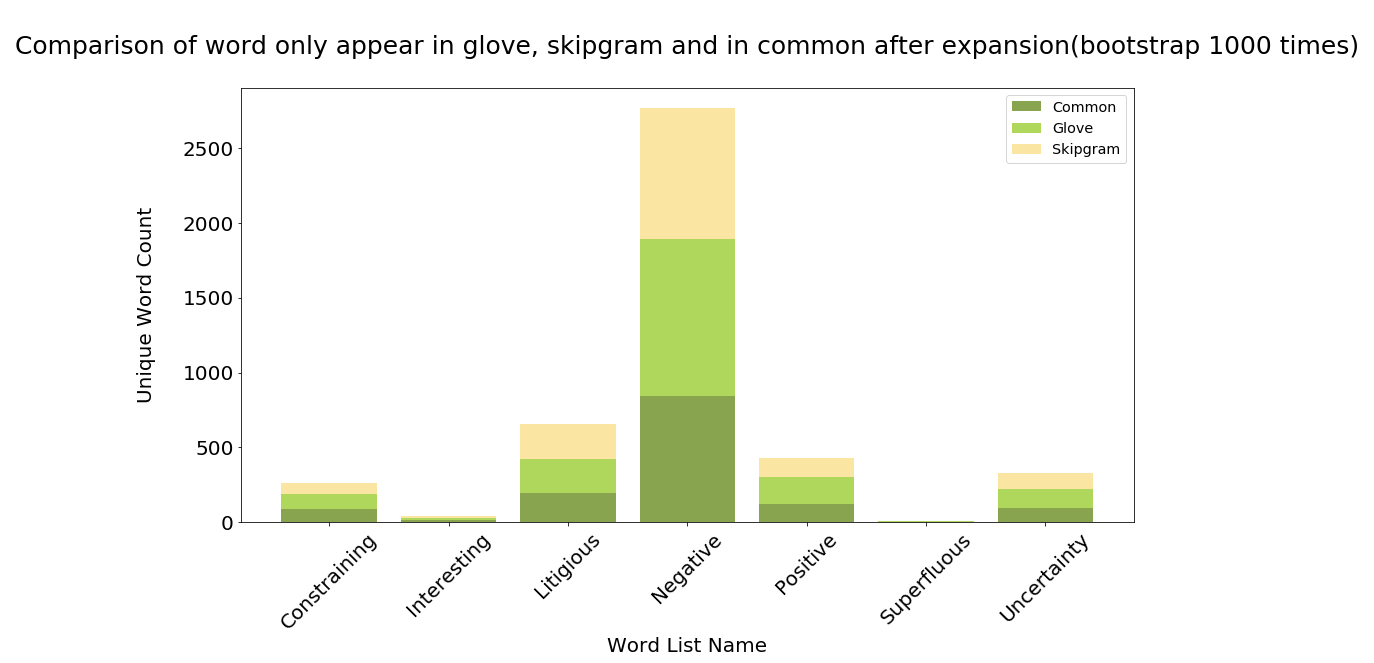

In [197]:
plt.figure(figsize=(16.0,8.0))
x1 = ['Constraining','Interesting','Litigious','Negative','Positive','Superfluous','Uncertainty']

y1 = result['common_unique1']
p1=plt.bar(x1, y1, label = "common",color='olivedrab',alpha=0.8)

y2 = result['glove_unique1']
plt.bar(x1, y2, label = "glove",bottom=y1,color='yellowgreen',alpha=0.8)
p3=plt.xlabel('Word List Name',size=20)
           
y3 = result['skipgram_unique']
p2=plt.bar(x1, y3, label = "skipgram",bottom=y1+y2,color='#fbe5a3',alpha=1)

# p3=plt.plot(x1,result['length_of_list'],linewidth=2,color='lightgrey')

plt.legend(('Common', 'Glove', 'Skipgram'),fontsize='x-large')
plt.xlabel('Word List Name',size=20)
plt.ylabel('Unique Word Count\n',size=20)
plt.xticks(rotation=45,size=20)
plt.yticks(size=20)
plt.title('\n Comparison of word only appear in glove, skipgram and in common after expansion(bootstrap 1000 times) \n',size=25)
plt.show()

In [ ]:
plt.figure(figsize=(16.0,8.0))
x1 = ['Constraining','Interesting','Litigious','Negative','Positive','Superfluous','Uncertainty']

y1 = result['common_unique2']
p1=plt.bar(x1, y1, label = "common",color='lightgrey')

y2 = result['glove_unique2']
plt.bar(x1, y2, label = "glove",bottom=y1,color='olivedrab')
p3=plt.xlabel('Word List Name',size=20)
           
y3 = result['skipgram_unique']
p2=plt.bar(x1, y3, label = "skipgram",bottom=y1+y2,color='yellowgreen')

# p3=plt.plot(x1,result['length_of_list'],linewidth=2,color='lightgrey')

plt.legend(('Common', 'Glove', 'Skipgram'),fontsize='x-large')
plt.xlabel('Word List Name',size=20)
plt.ylabel('Unique word count',size=20)
plt.xticks(rotation=45,size=20)
plt.yticks(size=20)
plt.title('\n Comparison of word only appear in glove, skipgram and in common after expansion(bootstrap 1000 times) \n',size=25)
plt.show()

In [123]:
len(d['Constraining_word-list'])

171

In [316]:
glove_exp_dict6['uncertainty']

[('uncertainty', 1.0),
 ('uncertainties', 0.8688303028019),
 ('turmoil', 0.831952481694997),
 ('concerns', 0.8263666586123463),
 ('worries', 0.8253518060303724),
 ('lingering', 0.8221628849117677),
 ('pressures', 0.8159942597939047),
 ('volatility', 0.8156865026952569),
 ('doubts', 0.8144181306786011),
 ('inevitably', 0.8094499162335165),
 ('concern', 0.8067499778290311),
 ('instability', 0.8041421865999991),
 ('inevitable', 0.8003305394597572),
 ('weakness', 0.793081731974294),
 ('fears', 0.7891978340148225),
 ('crisis', 0.7880904098139268),
 ('troubles', 0.7856483806813535),
 ('implications', 0.7842122037684394),
 ('confusion', 0.7817951604499453),
 ('risks', 0.7769518634914779),
 ('reflects', 0.7751585500058908),
 ('speculation', 0.7750248785275857),
 ('impact', 0.7713676898444523),
 ('uncertain', 0.7684946098234511),
 ('pessimism', 0.7667118333873988),
 ('tension', 0.7665751440256732),
 ('nervousness', 0.7618402328184204),
 ('geopolitical', 0.7604505714137629),
 ('repercussions', 0

In [ ]:
result['length_of_list'] = [171,63,517,1933,334,41,259]

In [237]:
# full_p = np.vstack((sk_p1,gl_p1,sk_p2,gl_p2,sk_p3,gl_p3,sk_p4,gl_p4,sk_p5,gl_p5,sk_p6,gl_p6))

In [238]:
# percentile_df = pd.DataFrame(full_p)

In [258]:
# percentile_df.columns = ["5%","20%","25%","50%","75%","90%","95%","model","count"]
# percentile_df["model"] = ['skipgram',"glove"]*6
# percentile_df["word list"] = ['Interesting']*2 + ['Litigious']*2 + ['Negative']*2 + ['Positive']*2 + ['Superfluous']*2 + ['Uncertainty']*2
# percentile_df["count"] = [np.mean(overlap1)]*2 + [np.mean(overlap2)]*2 + [np.mean(overlap3)]*2 + [np.mean(overlap4)]*2 + [np.mean(overlap5)]*2 + [np.mean(overlap6)]*2

In [ ]:
# percentile_df.set_index('word list')

In [137]:
# len:259
count = []
common = []
sk_set = set()
gl_set = set()
for (k1,v1), (k2,v2) in zip(glove_exp_dict6.items(), sk_exp_dict6.items()):
    share = set(list(zip(*v1))[0]).intersection(list(zip(*v2))[0])
    sk_set = sk_set.union(list(set(list(zip(*v1))[0])-share))
    gl_set = gl_set.union(list(set(list(zip(*v2))[0])-share))  
    c = len(share)
    common.append(share)
    count.append(c)

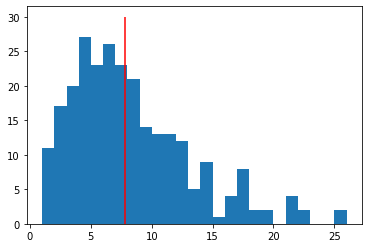

In [158]:
plt.hist(count,bins=25)
plt.vlines(x = np.mean(count),ymin=0,ymax=30,color = 'red')
plt.show()

In [82]:
np.mean(count)

7.77992277992278

In [161]:
freq_sk = []
for w in list(sk_set):
    try:
        freq_sk.append(freq_d[w])
    except KeyError:
        freq_sk.append("N/A")

In [165]:
freq_gl = []
for w in list(gl_set):
    try:
        freq_gl.append(freq_d[w])
    except KeyError:
        freq_gl.append("N/A")

In [164]:
np.percentile(a = [freq for freq in freq_sk if freq!= 'N/A'],q = [5,20,25,50,75,90,95] )

array([0.0000000e+00, 2.2300000e-09, 5.4750000e-09, 2.1100000e-07,
       5.7625000e-06, 5.5510000e-05, 1.8272475e-04])

In [166]:
np.percentile(a = [freq for freq in freq_gl if freq!= 'N/A'],q = [5,20,25,50,75,90,95] )

array([9.3725000e-09, 6.9500000e-08, 1.0600000e-07, 8.6050000e-07,
       8.2850000e-06, 5.6550000e-05, 1.4715725e-04])

In [114]:
words_we_care = set()
for dc in [glove_exp_dict1, glove_exp_dict2, glove_exp_dict3, glove_exp_dict4, glove_exp_dict5,glove_exp_dict6,sk_exp_dict1,sk_exp_dict2,sk_exp_dict3,sk_exp_dict4,sk_exp_dict5,sk_exp_dict6]:
    for k,v in dc.items():
        words_we_care = words_we_care.union(set(list(zip(*v))[0]))

In [118]:
words_we_care

{'staginess',
 'companyset',
 'globalnet',
 'brazenly',
 'disputed',
 'itus',
 'reaffirmation',
 'redevelopment',
 'appendices',
 'promotes',
 'teaching-learning',
 'businessissued',
 'qornet',
 'ninety',
 'unpardonable',
 'interconnectivity',
 'fenced',
 'comframe',
 'media',
 'reactivating',
 'leitmotif',
 'trunklines',
 'systematized',
 'serp',
 'sabha',
 'agencypet',
 'programplease',
 '1,023',
 'nudity',
 'lhfs',
 'powerpowers',
 'subconcessions',
 'preservatives',
 'dehumanized',
 'subpoenas',
 'sub-set',
 'deidesignated',
 'hwf',
 'third-largest',
 'archetype',
 'resectable',
 'boons',
 'vaccuum',
 'nonofficer',
 'staplers',
 'imagina',
 'volvio',
 'azealia',
 'verum',
 'fictionalizing',
 'bless',
 'georgia',
 'productions',
 'juries',
 'whimsies',
 'paymer',
 'crossbred',
 'reassign',
 'libellous',
 'unusually',
 'sublessee',
 'entrenches',
 'exercisablerange',
 'llcers',
 'extends',
 'sitessignificant',
 'migrate',
 'sardonic',
 'georgias',
 'defiantly',
 'toothaches',
 'demen

In [119]:
words_we_care_ls = list(words_we_care)

In [127]:
words_we_care_str = ("; ").join(words_we_care_ls)

In [128]:
txtfile = open("words.txt",'wt')
txtfile.write(words_we_care_str)
txtfile.close()

In [88]:
test = 'we are now in a uncertainty era, everything is uncertainty'

In [90]:
count = len(re.findall('uncertainty',test))

In [91]:
count

2